# Data-driven Spatial Branch-and-bound

### 📦 Installation: `pyDDSBB` Package

To install the `pyDDSBB` package directly from GitHub, use the following command:

```bash
pip install git+https://github.com/DDPSE/PyDDSBB/


To update the package to the latest version on GitHub, use:

```bash
pip install --upgrade git+https://github.com/DDPSE/PyDDSBB/

---

## 🧪 Examples of Optimization Problems

Below are examples of:

1. **Box-constrained problem**  
2. **Black-box equation-constrained problem**  
3. **Grey-box equation-constrained problem**

---


In [1]:
import PyDDSBB  ## import the pyDDSBB package
import numpy as np

## Box-Constrained Problem


\begin{aligned}
\min_{\mathbf{x}} \quad & f(\mathbf{x}) \\
\text{s.t.} \quad & \mathbf{x}_{\text{lb}} \le \mathbf{x} \le \mathbf{x}_{\text{ub}} \\
& \mathbf{x} \in \mathbb{R}^N
\end{aligned}


---

###  Example

The objective function $ f(x_1, x_2) $ is defined as:


\begin{aligned}
f(x_1, x_2) =\ & -0.5 \cdot \exp\left(-100(x_1^2 + x_2^2)\right) \\
& - 1.2 \cdot \exp\left(-4((-1 + x_1)^2 + x_2^2)\right) \\
& - \exp\left(-3(x_1^2 + (0.5 + x_2)^2)\right) \\
& - \exp\left(-2((0.5 + x_1)^2 + x_2^2)\right) \\
& - 1.2 \cdot \exp\left(-4(x_1^2 + (-1 + x_2)^2)\right)
\end{aligned}


### Variable Bounds
>  $ -1 \le x_1 \le 1, \quad -1 \le x_2 \le 1 $

> ✅ **Global optimum:** $ f(x) = -1.6360 $ at $ x = [-0.01044, -0.01273] $


In [2]:
def multiGauss(x):
    f = (-0.5*np.exp(-100*(x[0]**2 + x[1]**2))) - 1.2*np.exp(-4*((-1 + x[0])**2 + x[1]**2)) -\
        np.exp(-3*(x[0]**2+ (0.5 + x[1])**2)) - np.exp(-2*((0.5 + x[0])**2 + x[1]**2)) - 1.2*np.exp(-4*(x[0]**2 + (-1 + x[1])**2))
    return float(f)

### Step 1: Define the Model

In [3]:
model_bcp = PyDDSBB.DDSBBModel.Problem() ## Initialize the model
model_bcp.add_objective(multiGauss, sense = 'minimize') ##  add objective function, default: minimize
model_bcp.add_variable(-1.0, 1.0) ## add variable bounds (must be float point)
model_bcp.add_variable(-1.0, 1.0) ## add variable bounds (must be float point)
print('problem dimensionality : ' + str(model_bcp._dim))  ## Dimension is counted 

problem dimensionality : 2


### Step 2: Specify DDSBB Solver Options

Below are the configurable options for the `DDSBB` solver:

---

#### ✅ `multifidelity`: `bool`  
- Enables or disables the multifidelity approach.  
- **Default:** `False`  
- **Options:**  
  - `True`: Turn **on** multifidelity  
  - `False`: Turn **off** multifidelity

---

#### 🔀 `split_method`: `str`  
- Strategy to determine the split point along a dimension.  
- **Options:**  
  - For **all problems**:  
    - `'equal_bisection'` (default)  
    - `'golden_section'`  
  - For **constrained problems only**:  
    - `'purity'`  
    - `'gini'`

---

#### 📏 `variable_selection`: `str`  
- Strategy to choose which variable/dimension to split.  
- **Options:**  
  - `'longest_side'` (default; all problems)  
  - `'svr_var_select'` (all problems)  
  - `'purity'`, `'gini'` (for constrained problems)

---

#### 📉 `underestimator_option`: `str`  
- Type of underestimator used during the optimization.  
- **Options:**  
  - `'Quadratic'` (default; all problems)  
  - `'Lipschitz-QU'` (estimates local lipschitz constant and requires **Gurobi** solver)  

---

#### ⏱️ `stop_option`: `dict`  
Defines stopping criteria for the solver. Includes:  
- `absolute_tolerance`: `float`  
  - Tolerance for the absolute gap between upper and lower bounds  
- `relative_tolerance`: `float`  
  - Relative gap tolerance = absolute gap / |lower bound|  
- `minimum_bound`: `float`  
  - Minimum bound distance in the input space  
- `sampling_limit`: `int`  
  - Maximum number of samples allowed  
- `time_limit`: `float`  
  - Maximum runtime in seconds

---

#### 🎯 `sense`: `str`  
- Direction of optimization.  
- **Options:** `'minimize'`, `'maximize'`

---

#### 🧠 `adaptive_sampling`: `function(level, dimension)`  
- Function to define adaptive sampling strategy as a function of level and problem dimensionality.


In [4]:
#initial number of samples = 21
np.random.seed(100)
bcp_solver = PyDDSBB.DDSBB(21, underestimator_option = 'Quadratic',split_method = 'equal_bisection', \
                           variable_selection = 'longest_side', multifidelity = False, \
                           stop_option = {'absolute_tolerance': 0.05, 'relative_tolerance': 0.01, \
                                          'minimum_bound': 0.05, 'sampling_limit': 300, 'time_limit': 5000})

###  Step 3: Optimize

Run the optimization using the specified model and solver settings.

---

In [5]:
bcp_solver.optimize(model_bcp)
bcp_solver.print_result()
yopt_bcp = bcp_solver.get_optimum()  ### Get optimal solution 
xopt_bcp = bcp_solver.get_optimizer() ### Get optimizer
print('yopt : ' + str(yopt_bcp))
print('xopt : ' + str(xopt_bcp))

absolute gap closed
Time elapsed: 0.27s
Current level: 0
Current node: 0
Number of samples used: 23
Current best upper bound :  -1.587759231156731
Current best lower bound :  -1.5886209876876403
Current absolute gap:  0.0008617565309092523
Current best optimizer: [[ 0.01970481 -0.02178725]]
yopt : -1.587759231156731
xopt : [[ 0.01970481 -0.02178725]]


---
### Step 4 (optional) : resume the search with more samples

Increase the total sampling limit to 500

---

In [6]:
bcp_solver.resume({'sampling_limit': 500})
bcp_solver.print_result()
yopt_bcp = bcp_solver.get_optimum()  ### Get optimal solution 
xopt_bcp = bcp_solver.get_optimizer() ### Get optimizer
print('yopt : ' + str(yopt_bcp))
print('xopt : ' + str(xopt_bcp))

Resume search with new resources
absolute gap closed
Time elapsed: 1.92s
Current level: 3
Current node: 14
Number of samples used: 85
Current best upper bound :  -1.6228547457866103
Current best lower bound :  -1.6478153318624411
Current absolute gap:  0.02496058607583085
Current best optimizer: [[0. 0.]]
yopt : -1.6228547457866103
xopt : [[0. 0.]]


---
### Run with a different underestimator option

Set the underestimator as Lipschitz-QU

---

**Run with underestimator_option = 'Lipschitz-QU':**

    This requires Gurobi solver to run 
    
    Obtain a license for Gurobi, more information here: https://www.gurobi.com/academia/academic-program-and-licenses/
    
    The solver options can be modified in _underestimators.py 

In [7]:
#initial number of samples = 21
np.random.seed(100)
bcp_solver_LC = PyDDSBB.DDSBB(21, underestimator_option = 'Lipschitz-QU',split_method = 'equal_bisection', \
                           variable_selection = 'longest_side', multifidelity = False, \
                           stop_option = {'absolute_tolerance': 0.05, 'relative_tolerance': 0.01, \
                                          'minimum_bound': 0.05, 'sampling_limit': 300, 'time_limit': 5000})

bcp_solver_LC.optimize(model_bcp)
bcp_solver_LC.print_result()
yopt_bcp = bcp_solver_LC.get_optimum()  ### Get optimal solution 
xopt_bcp = bcp_solver_LC.get_optimizer() ### Get optimizer
print('yopt : ' + str(yopt_bcp))
print('xopt : ' + str(xopt_bcp))

reached sampling limit without search all active nodes in level 10
Time elapsed: 33.37s
Current level: 10
Current node: 62
Number of samples used: 306
Current best upper bound :  -1.6228547457866103
Current best lower bound :  -1.8026217766826842
Current absolute gap:  0.17976703089607393
Current best optimizer: [[0. 0.]]
yopt : -1.6228547457866103
xopt : [[0. 0.]]


---

**Run with underestimator_option = 'Hybrid-Lipschitz-QU':**

    This requires Gurobi solver to run 
    
    Obtain a license for Gurobi, more information here: https://www.gurobi.com/academia/academic-program-and-licenses/
    
    The solver options can be modified in _underestimators.py  
    
    Tune the solver options in _underestimators.py, Gurobi can take some presolve time

In [8]:
#initial number of samples = 21
np.random.seed(100)
bcp_solver_LC_IC = PyDDSBB.DDSBB(21, underestimator_option = 'Hybrid-Lipschitz-QU',split_method = 'equal_bisection', \
                           variable_selection = 'longest_side', multifidelity = False, \
                           stop_option = {'absolute_tolerance': 0.05, 'relative_tolerance': 0.01, \
                                          'minimum_bound': 0.05, 'sampling_limit': 300, 'time_limit': 5000})

bcp_solver_LC_IC.optimize(model_bcp)
bcp_solver_LC_IC.print_result()
yopt_bcp = bcp_solver_LC_IC.get_optimum()  ### Get optimal solution 
xopt_bcp = bcp_solver_LC_IC.get_optimizer() ### Get optimizer
print('yopt : ' + str(yopt_bcp))
print('xopt : ' + str(xopt_bcp))

absolute gap closed
Time elapsed: 28.06s
Current level: 8
Current node: 56
Number of samples used: 275
Current best upper bound :  -1.6228547457866103
Current best lower bound :  -1.6360317691113841
Current absolute gap:  0.013177023324773884
Current best optimizer: [[0. 0.]]
yopt : -1.6228547457866103
xopt : [[0. 0.]]


---

**Run with underestimator_option = 'Lipschitz-QUB':**
    
    Runs with glpk solver

In [9]:
#initial number of samples = 21
np.random.seed(100)
bcp_solver_LC_bound = PyDDSBB.DDSBB(21, underestimator_option = 'Lipschitz-QUB',split_method = 'equal_bisection', \
                           variable_selection = 'longest_side', multifidelity = False, \
                           stop_option = {'absolute_tolerance': 0.05, 'relative_tolerance': 0.01, \
                                          'minimum_bound': 0.05, 'sampling_limit': 300, 'time_limit': 5000})

bcp_solver_LC_bound.optimize(model_bcp)
bcp_solver_LC_bound.print_result()
yopt_bcp = bcp_solver_LC_bound.get_optimum()  ### Get optimal solution 
xopt_bcp = bcp_solver_LC_bound.get_optimizer() ### Get optimizer
print('yopt : ' + str(yopt_bcp))
print('xopt : ' + str(xopt_bcp))

reached sampling limit without search all active nodes in level 5
Time elapsed: 11.4s
Current level: 5
Current node: 58
Number of samples used: 300
Current best upper bound :  -1.6228547457866103
Current best lower bound :  -5.873295512888452
Current absolute gap:  4.250440767101842
Current best optimizer: [[0. 0.]]
yopt : -1.6228547457866103
xopt : [[0. 0.]]


## Black-box Equation-Constrained Problems


\begin{aligned}
\min_{\mathbf{x}} \quad & f(\mathbf{x}) \\
\text{s.t.} \quad & \mathbf{x}_{\text{lb}} \le \mathbf{x} \le \mathbf{x}_{\text{ub}} \\
& g(\mathbf{x}) \le 0 \\
& \mathbf{x} \in \mathbb{R}^N
\end{aligned}


> **Note:** The constraint function $g(\mathbf{x}) $ is unknown.

---

### Method

1. Samples are labeled as:
   - **1** → Feasible  
   - **0** → Infeasible  
2. A node is pruned if:
   - It contains **only infeasible samples**, or  
   - The **local lower bound** exceeds the **global upper bound**

---

### Example Problem


\begin{aligned}
\min_{x_1, x_2} \quad & x_1 \\
\text{s.t.} \quad & 0.25x_1 - 0.0625(x_1^2 + x_2^2) + 0.5x_2 \le 1.0 \\
& 0.071428(x_1^2 + x_2^2) - 0.42857(x_1 + x_2) \le -1.0 \\
& 1 \le x_1 \le 5.5 \\
& 1 \le x_2 \le 5.5
\end{aligned}


> ✅ **Solution:** Global optimum at \( x = [1.1771,\ 2.1771] \)  
>  **Objective value:** \( f(x) = 1.177 \)


In [10]:
def prob06(x):
    return x[0]
def prob06_cons(x):
    if 0.25*x[0] - 0.0625*x[0]**2 - 0.0625*x[1]**2 + 0.5*x[1] <= 1.0 and 0.0714285714285714*x[0]**2 + 0.0714285714285714*x[1]**2 - 0.428571428571429*x[0] -0.428571428571429*x[1] <= -1.0:
        return 1.
    else:
        return 0.

### Step 1: Define the model

In [11]:
model_blk = PyDDSBB.DDSBBModel.Problem()
model_blk.add_objective(prob06)
model_blk.add_unknown_constraint(prob06_cons)
model_blk.add_variable(1., 5.5)
model_blk.add_variable(1., 5.5)

### Step 2: Specify Solver

In [12]:
blk_solver = PyDDSBB.DDSBB(23, underestimator_option = 'Quadratic', split_method = 'equal_bisection',
                           variable_selection = 'longest_side', multifidelity = False, \
                           stop_option = {'absolute_tolerance': 0.05, 'relative_tolerance': 0.01, \
                                          'minimum_bound': 0.05, 'sampling_limit': 500, 'time_limit': 5000})

### Step 3: Optimize

In [13]:
blk_solver.optimize(model_blk)
blk_solver.print_result()
yopt_blk = blk_solver.get_optimum()  ### Get optimal solution 
xopt_blk = blk_solver.get_optimizer() ### Get optimizer
print('yopt : ' + str(yopt_blk))
print('xopt : ' + str(xopt_blk))

absolute gap closed
Time elapsed: 9.24s
Current level: 13
Current node: 84
Number of samples used: 419
Current best upper bound :  1.2109375
Current best lower bound :  1.17578125
Current absolute gap:  0.03515625
Current best optimizer: [[1.2109375 2.125    ]]
yopt : 1.2109375
xopt : [[1.2109375 2.125    ]]


## Grey-box Equation-Constrained Problem


\begin{aligned}
\min_{\mathbf{x}} \quad & f(\mathbf{x}) \\
\text{s.t.} \quad & \mathbf{x}_{\text{lb}} \le \mathbf{x} \le \mathbf{x}_{\text{ub}} \\
& g(\mathbf{x}) \le 0 \\
& \mathbf{x} \in \mathbb{R}^N
\end{aligned}


> ℹ️ In grey-box settings, the constraint function \( g(\mathbf{x}) \) is **partially or fully known**.

---

### Methods

1. Samples are labeled as:
   - **1** → Feasible  
   - **0** → Infeasible  
2. **Feasibility-based bound tightening** is applied at the root node to reduce the search space.  
3. A **constraint-violation minimization problem** is solved at each node to assess feasibility.

---

###  Example Problem

\begin{aligned}
\min_{x_1, x_2} \quad & x_1 \\
\text{s.t.} \quad & 0.25x_1 - 0.0625(x_1^2 + x_2^2) + 0.5x_2 \le 1.0 \quad \text{(known)} \\
& 0.071428(x_1^2 + x_2^2) - 0.42857(x_1 + x_2) \le -1.0 \quad \text{(unknown)} \\
& 1 \le x_1 \le 5.5 \\
& 1 \le x_2 \le 5.5
\end{aligned}


> ✅ **Solution:** Global optimum at \( x = [1.1771,\ 2.1771] \)  
> **Objective value:** \( f(x) = 1.177 \)


### Step 1: Define the model

In [14]:
model_gr = PyDDSBB.DDSBBModel.Problem()
model_gr.add_objective(prob06)
model_gr.add_unknown_constraint(prob06_cons)
model_gr.add_known_constraint('0.25*x0 - 0.0625*x0**2 - 0.0625*x1**2 + 0.5*x1 <= 1.0')
model_gr.add_variable(1., 5.5)
model_gr.add_variable(1., 5.5)

### Step 2: Specify the solver

In [15]:
gr_solver = PyDDSBB.DDSBB(23, underestimator_option = 'Quadratic', split_method = 'equal_bisection', \
                          variable_selection = 'longest_side', multifidelity = False, \
                          stop_option = {'absolute_tolerance': 0.05, 'relative_tolerance': 0.01, \
                                         'minimum_bound': 0.05, 'sampling_limit': 500, 'time_limit': 5000})

### Step 3: Optimize

In [16]:
gr_solver.optimize(model_gr)
gr_solver.print_result()
yopt_gr = gr_solver.get_optimum()  ### Get optimal solution 
xopt_gr = gr_solver.get_optimizer() ### Get optimizer
print('yopt : ' + str(yopt_gr))
print('xopt : ' + str(xopt_gr))

xlb after FBBT:  [1. 1.]
xub after FBBT:  [5.5 5.5]
absolute gap closed
Time elapsed: 15.01s
Current level: 13
Current node: 74
Number of samples used: 359
Current best upper bound :  1.2109375
Current best lower bound :  1.17578125
Current absolute gap:  0.03515625
Current best optimizer: [[1.2109375 2.125    ]]
yopt : 1.2109375
xopt : [[1.2109375 2.125    ]]


### Solve it as a glass-box problem 

In [17]:
model_gr.add_known_constraint('0.0714285714285714*x0**2 + 0.0714285714285714*x1**2 - 0.428571428571429*x0 -0.428571428571429*x1 <= -1.0')

In [18]:
gr_solver = PyDDSBB.DDSBB(23, underestimator_option = 'Quadratic', split_method = 'equal_bisection', \
                          variable_selection = 'longest_side', multifidelity = False, \
                          stop_option = {'absolute_tolerance': 0.05, 'relative_tolerance': 0.01, 
                                         'minimum_bound': 0.05, 'sampling_limit': 500, 'time_limit': 5000})
gr_solver.optimize(model_gr)
gr_solver.print_result()
yopt_gr = gr_solver.get_optimum()  ### Get optimal solution 
xopt_gr = gr_solver.get_optimizer() ### Get optimizer
print('yopt : ' + str(yopt_gr))
print('xopt : ' + str(xopt_gr))

xlb after FBBT:  [1.17712428 1.        ]
xub after FBBT:  [5.00000003 4.82287572]
absolute gap closed
Time elapsed: 6.94s
Current level: 11
Current node: 38
Number of samples used: 179
Current best upper bound :  1.1894527355056095
Current best lower bound :  1.1771242763412135
Current absolute gap:  0.012328459164395955
Current best optimizer: [[1.18945274 2.15238996]]
yopt : 1.1894527355056095
xopt : [[1.18945274 2.15238996]]


# Accessible Information and visualizations

In [19]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "georgia"

import warnings
warnings.filterwarnings("ignore")

In [20]:
## Access Tree 
bcp_solver.Tree[0][0].print_node()

Node level:   0
Node number:  0
Local upper bound:  -1.587759231156731
Local lower bound:  -1.5886209876876403
Local gap: 0.0008617565309092523
Node active


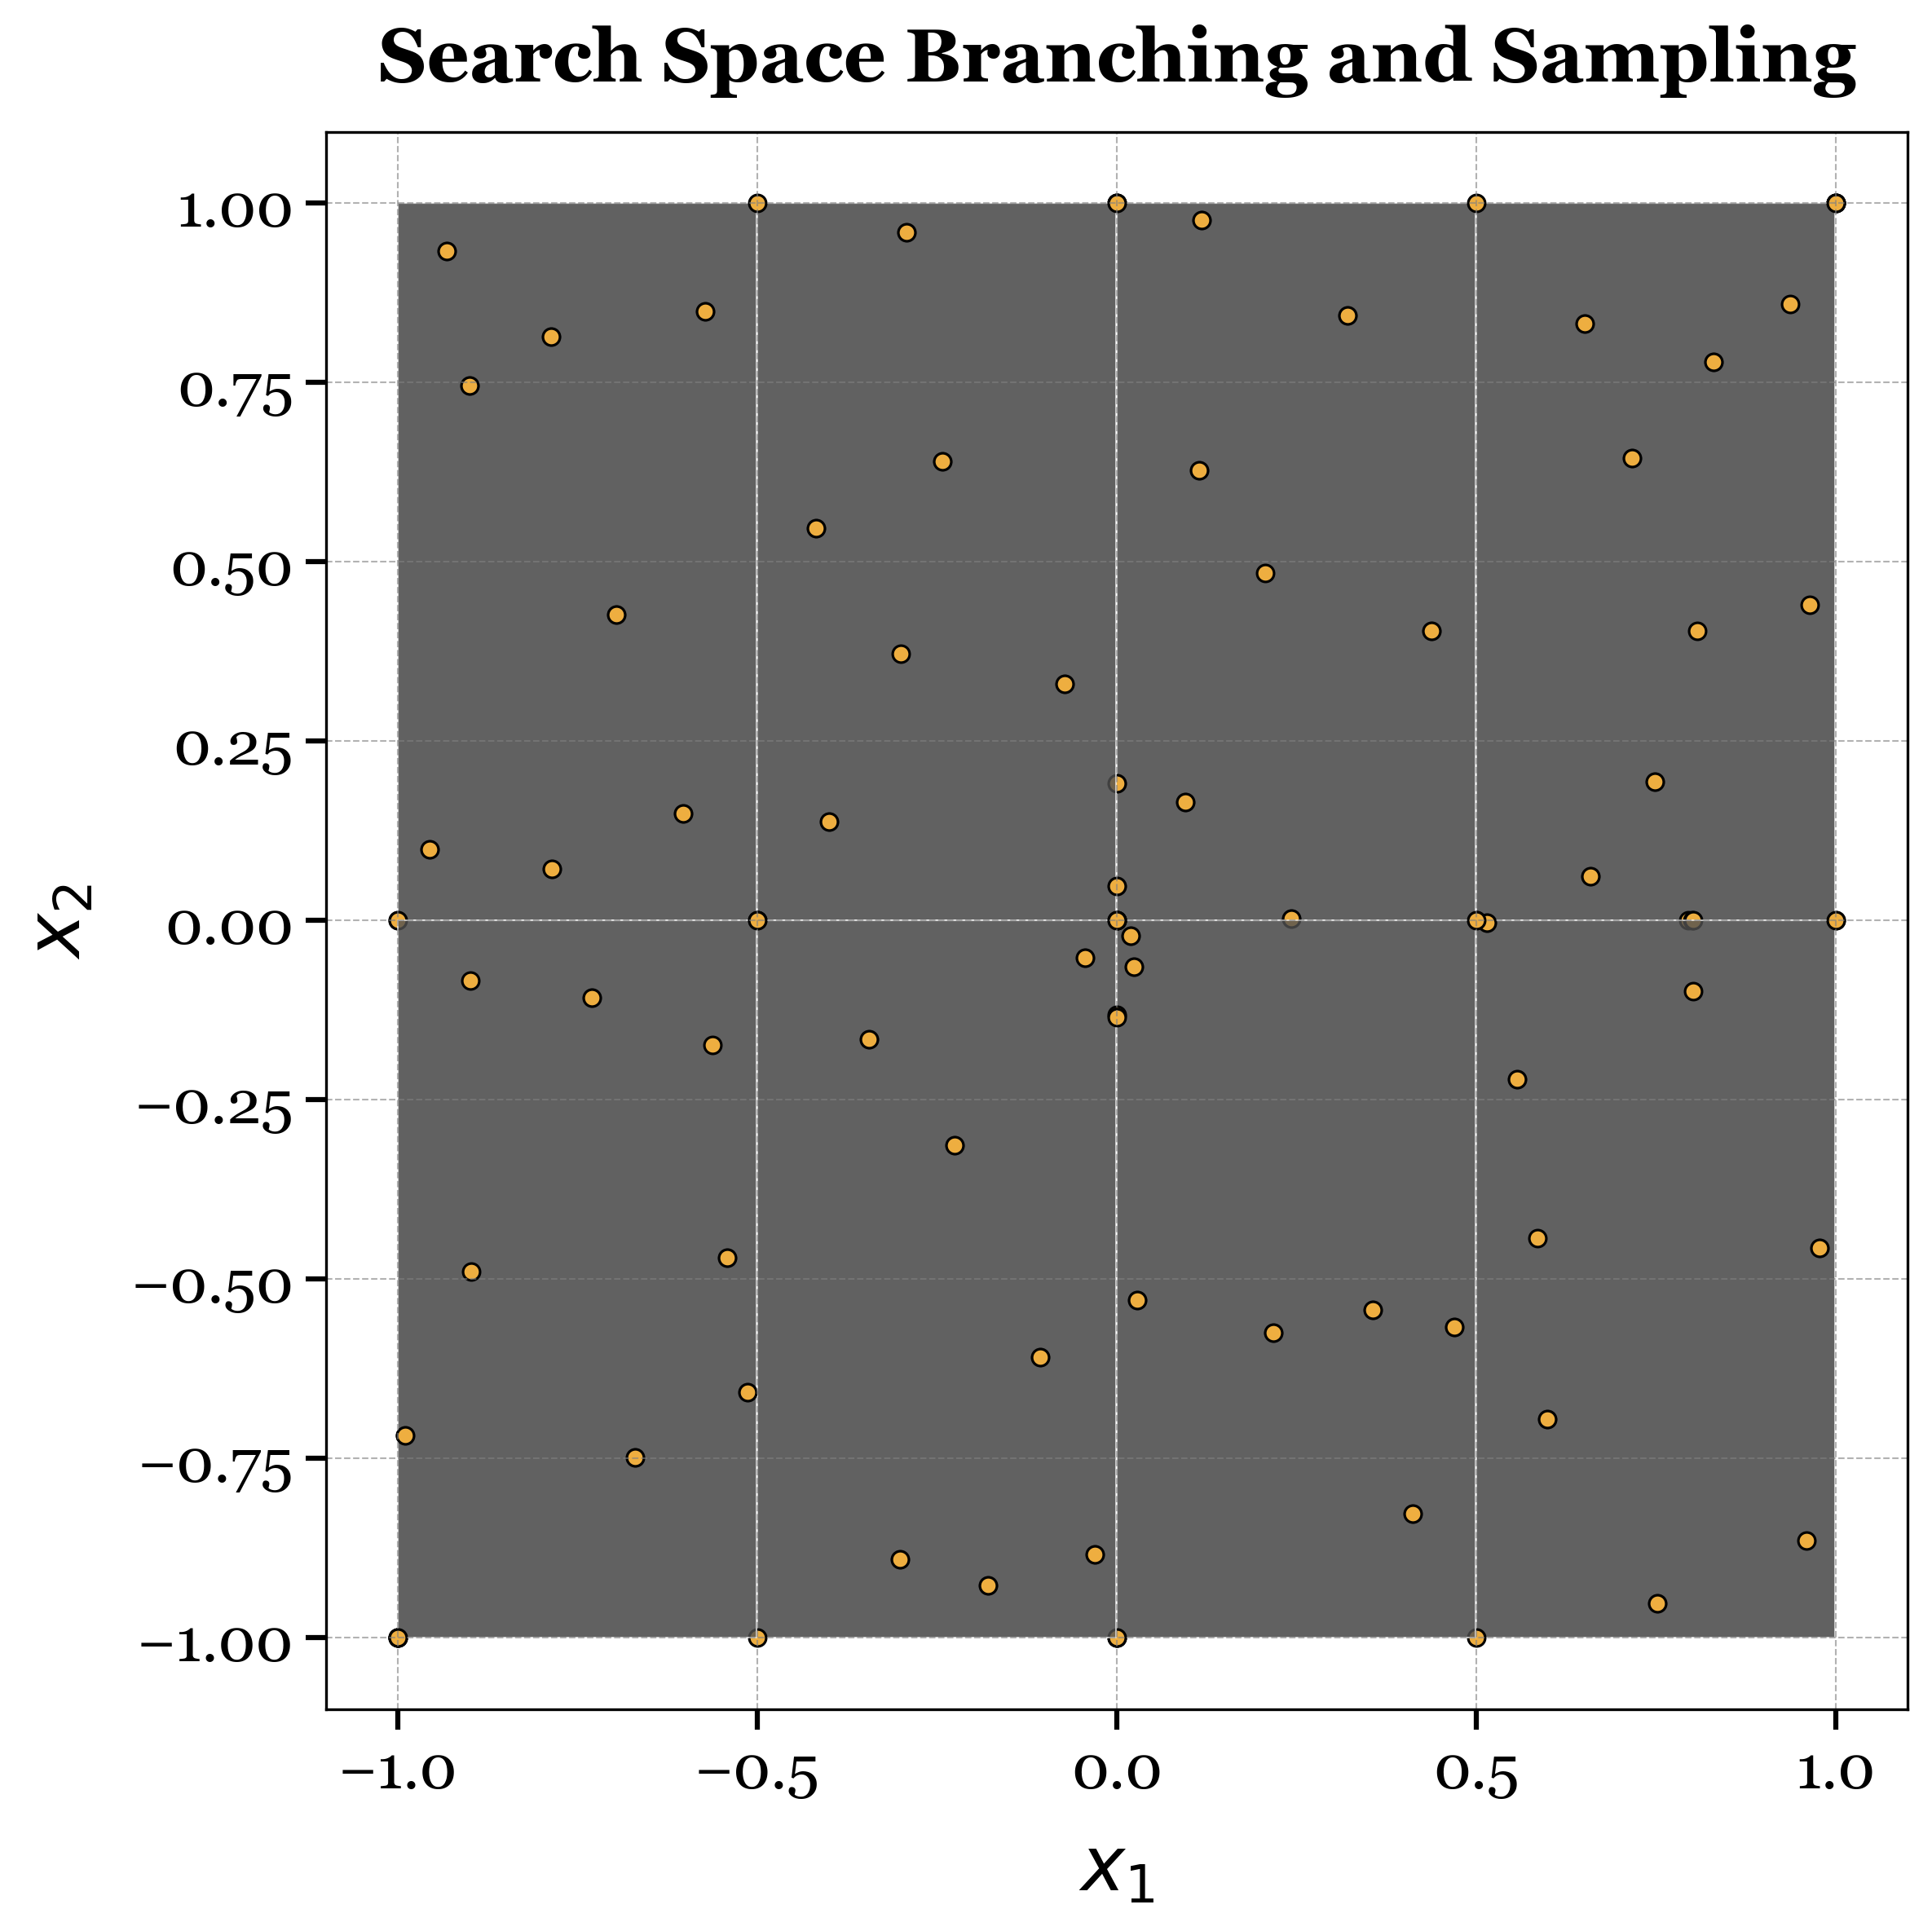

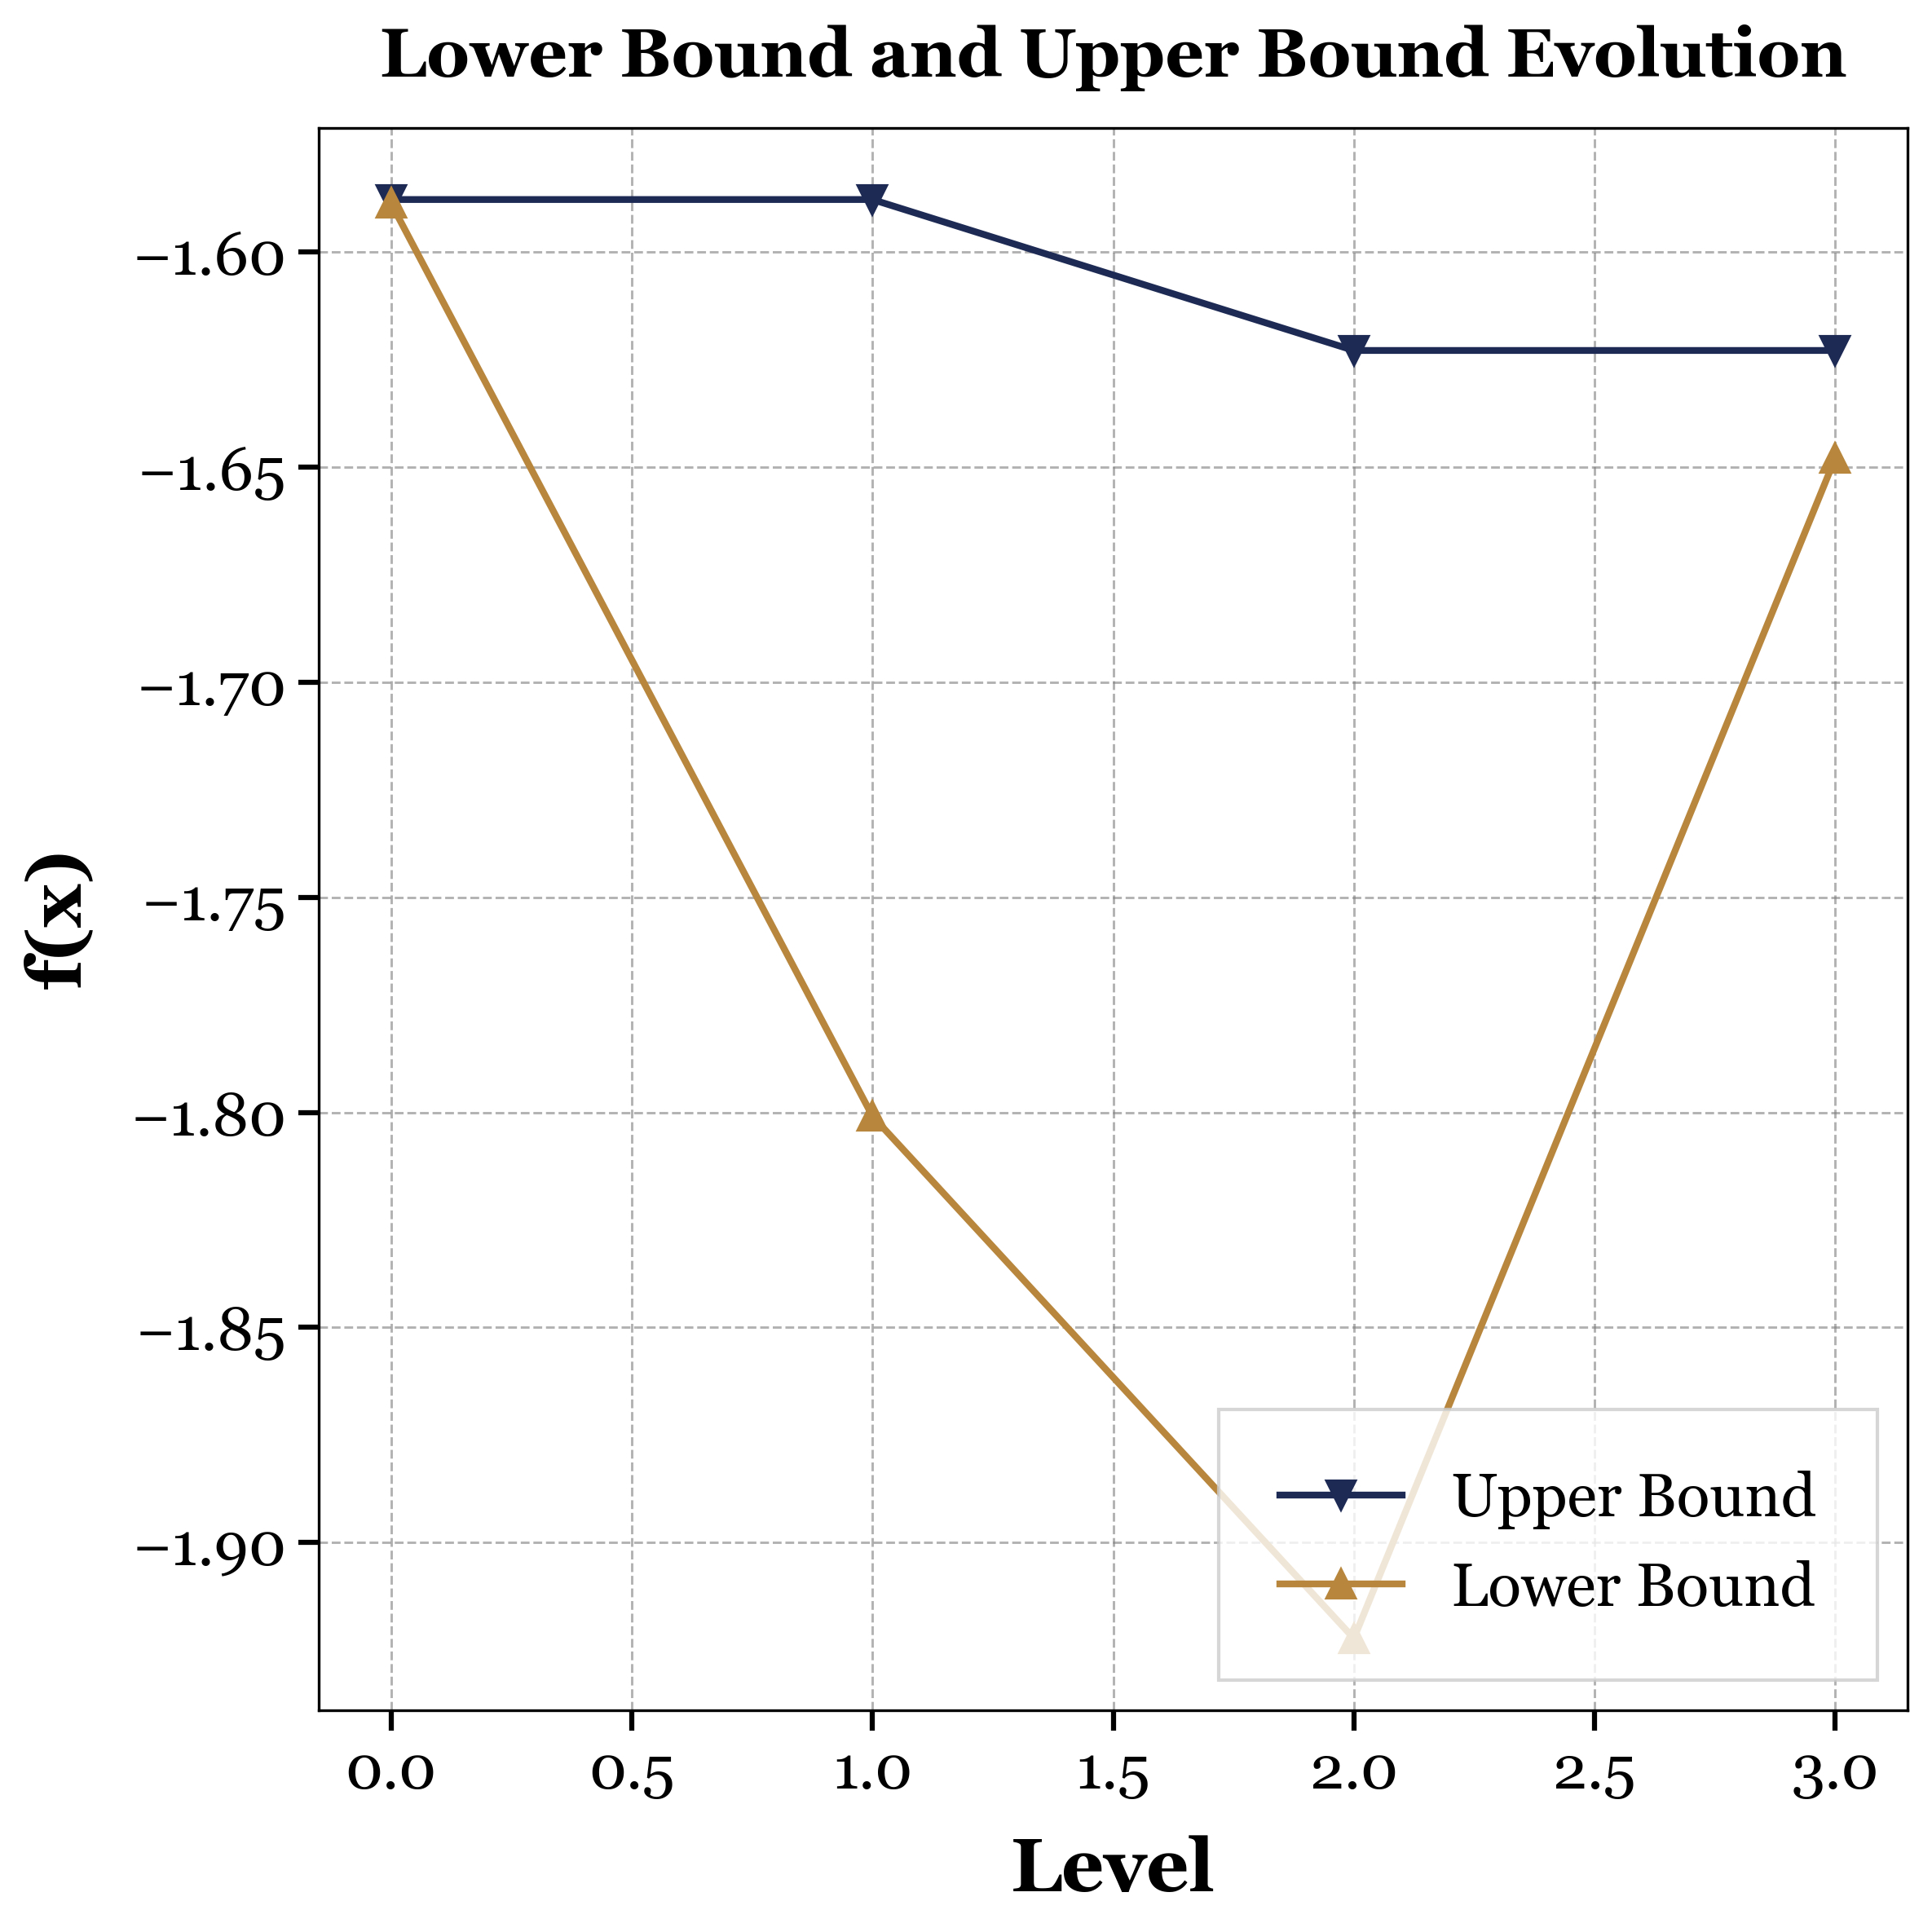

In [27]:
## Lowerbound and upperbound for quadratic underestimator
fig = plt.figure(figsize=(8, 8), dpi=300)
ax2 = fig.add_subplot(1, 1, 1)

marker_clr = '#EEAE40'
for level in bcp_solver.Tree.keys():
    for node in bcp_solver.Tree[level].values():
        shade1 = np.arange(node.bounds[0, 0], node.bounds[1, 0], 0.001)
        ax2.fill_between(
            shade1,
            node.bounds[1, 1],
            node.bounds[0, 1],
            facecolor=plt.cm.Greys(level / len(bcp_solver.Tree.keys())),
            edgecolor='white',
            linewidth=0.4,
            alpha=0.8
        )
        ax2.scatter(
            node.x[:, 0],
            node.x[:, 1],
            marker='.',
            s=100,
            c=marker_clr,
            edgecolors='black',
            linewidth=0.75
        )

ax2.set_xlabel('$x_1$', fontsize=22, fontweight='bold', labelpad=10)
ax2.set_ylabel('$x_2$', fontsize=22, fontweight='bold', labelpad=10)
ax2.tick_params(axis='both', labelsize=18, width=1.5, length=6)
ax2.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
ax2.set_title('Search Space Branching and Sampling', fontsize=22, fontweight='bold', pad=15)
plt.tight_layout()

plt.show()

###-------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8,8), dpi=300)
ax = fig.add_subplot(1, 1, 1)

levels = range(len(bcp_solver._lowerbound_hist))

ax.plot(
    levels, 
    bcp_solver._upperbound_hist, 
    label='Upper Bound', 
    color= '#1d2a54', 
    marker='v', 
    markersize=8, 
    linewidth=2
)
ax.plot(
    levels, 
    bcp_solver._lowerbound_hist, 
    label='Lower Bound', 
    color='#b8873d', 
    marker='^', 
    markersize=8, 
    linewidth=2
)
ax.set_xlabel('Level', fontsize=22, fontweight='bold', labelpad=10)
ax.set_ylabel('f(x)', fontsize=22, fontweight='bold', labelpad=10)

ax.tick_params(axis='both', labelsize=18, width=1.5, length=6)

ax.legend(
    fontsize=18, 
    frameon=True, 
    loc='lower right', 
    fancybox=False, 
    shadow=False, 
    borderpad=1
)

ax.grid(color='gray', linestyle='--', linewidth=0.7, alpha=0.6)
ax.set_title('Lower Bound and Upper Bound Evolution', fontsize=20, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()



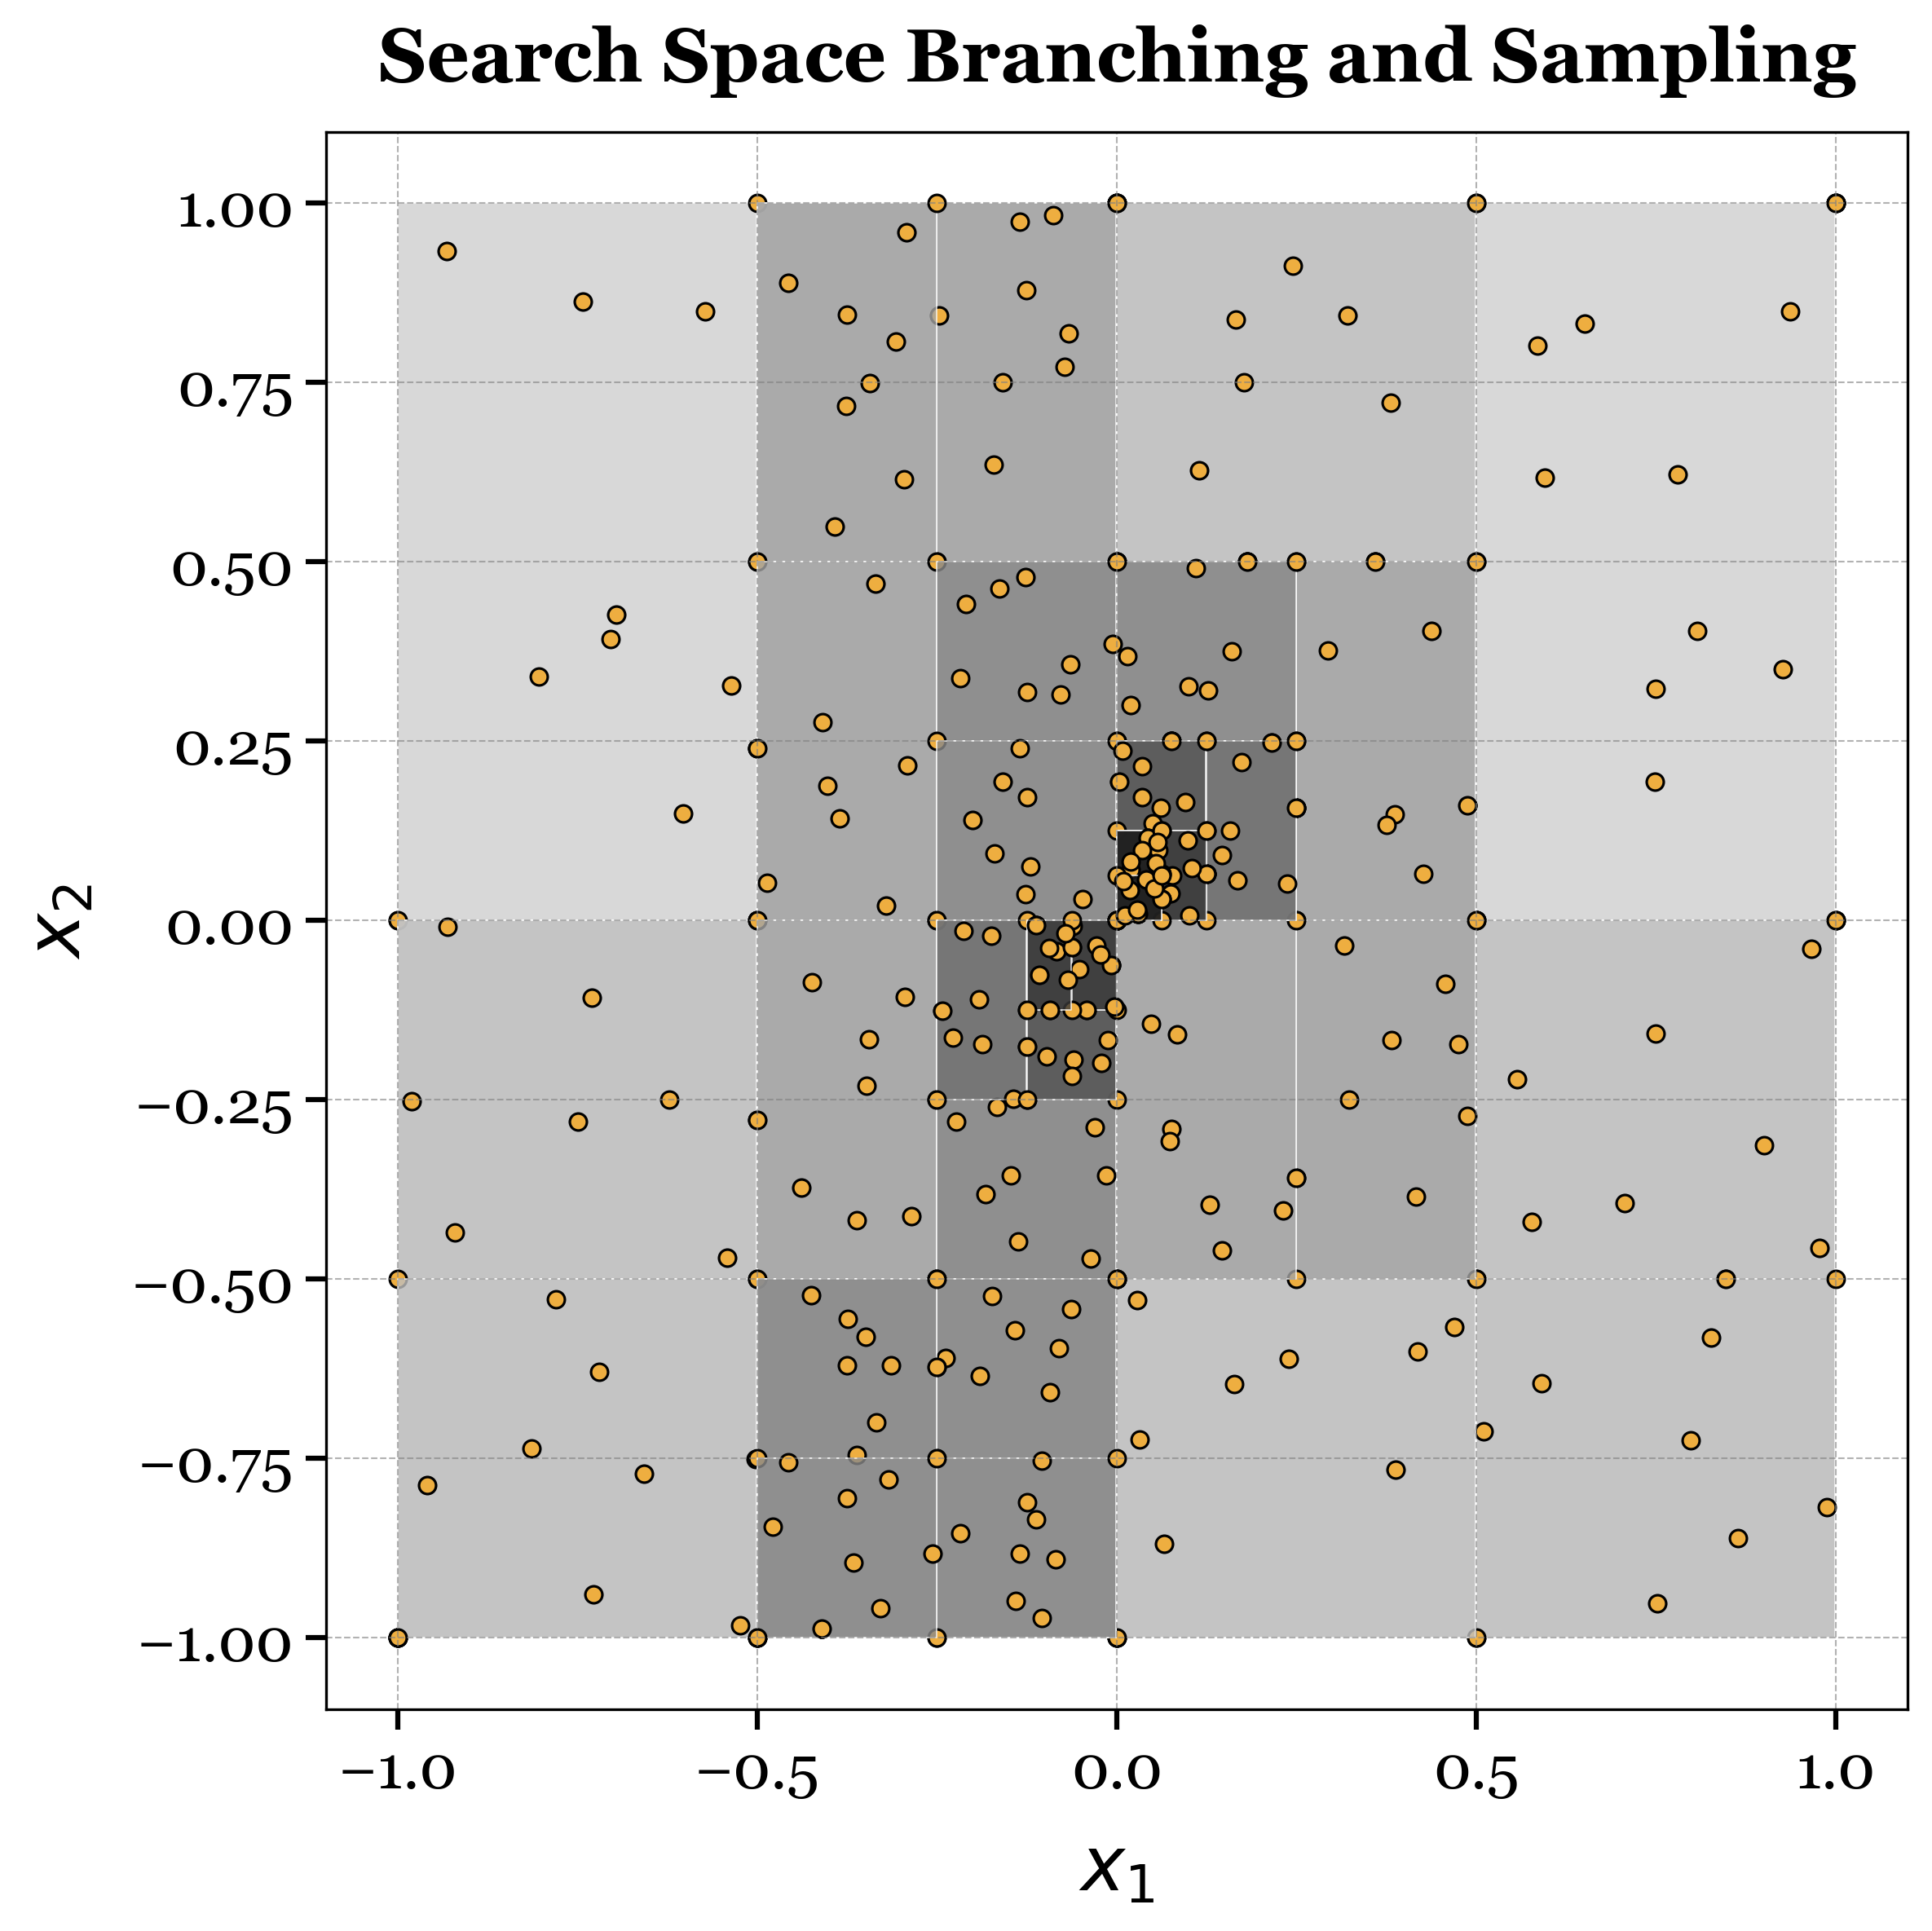

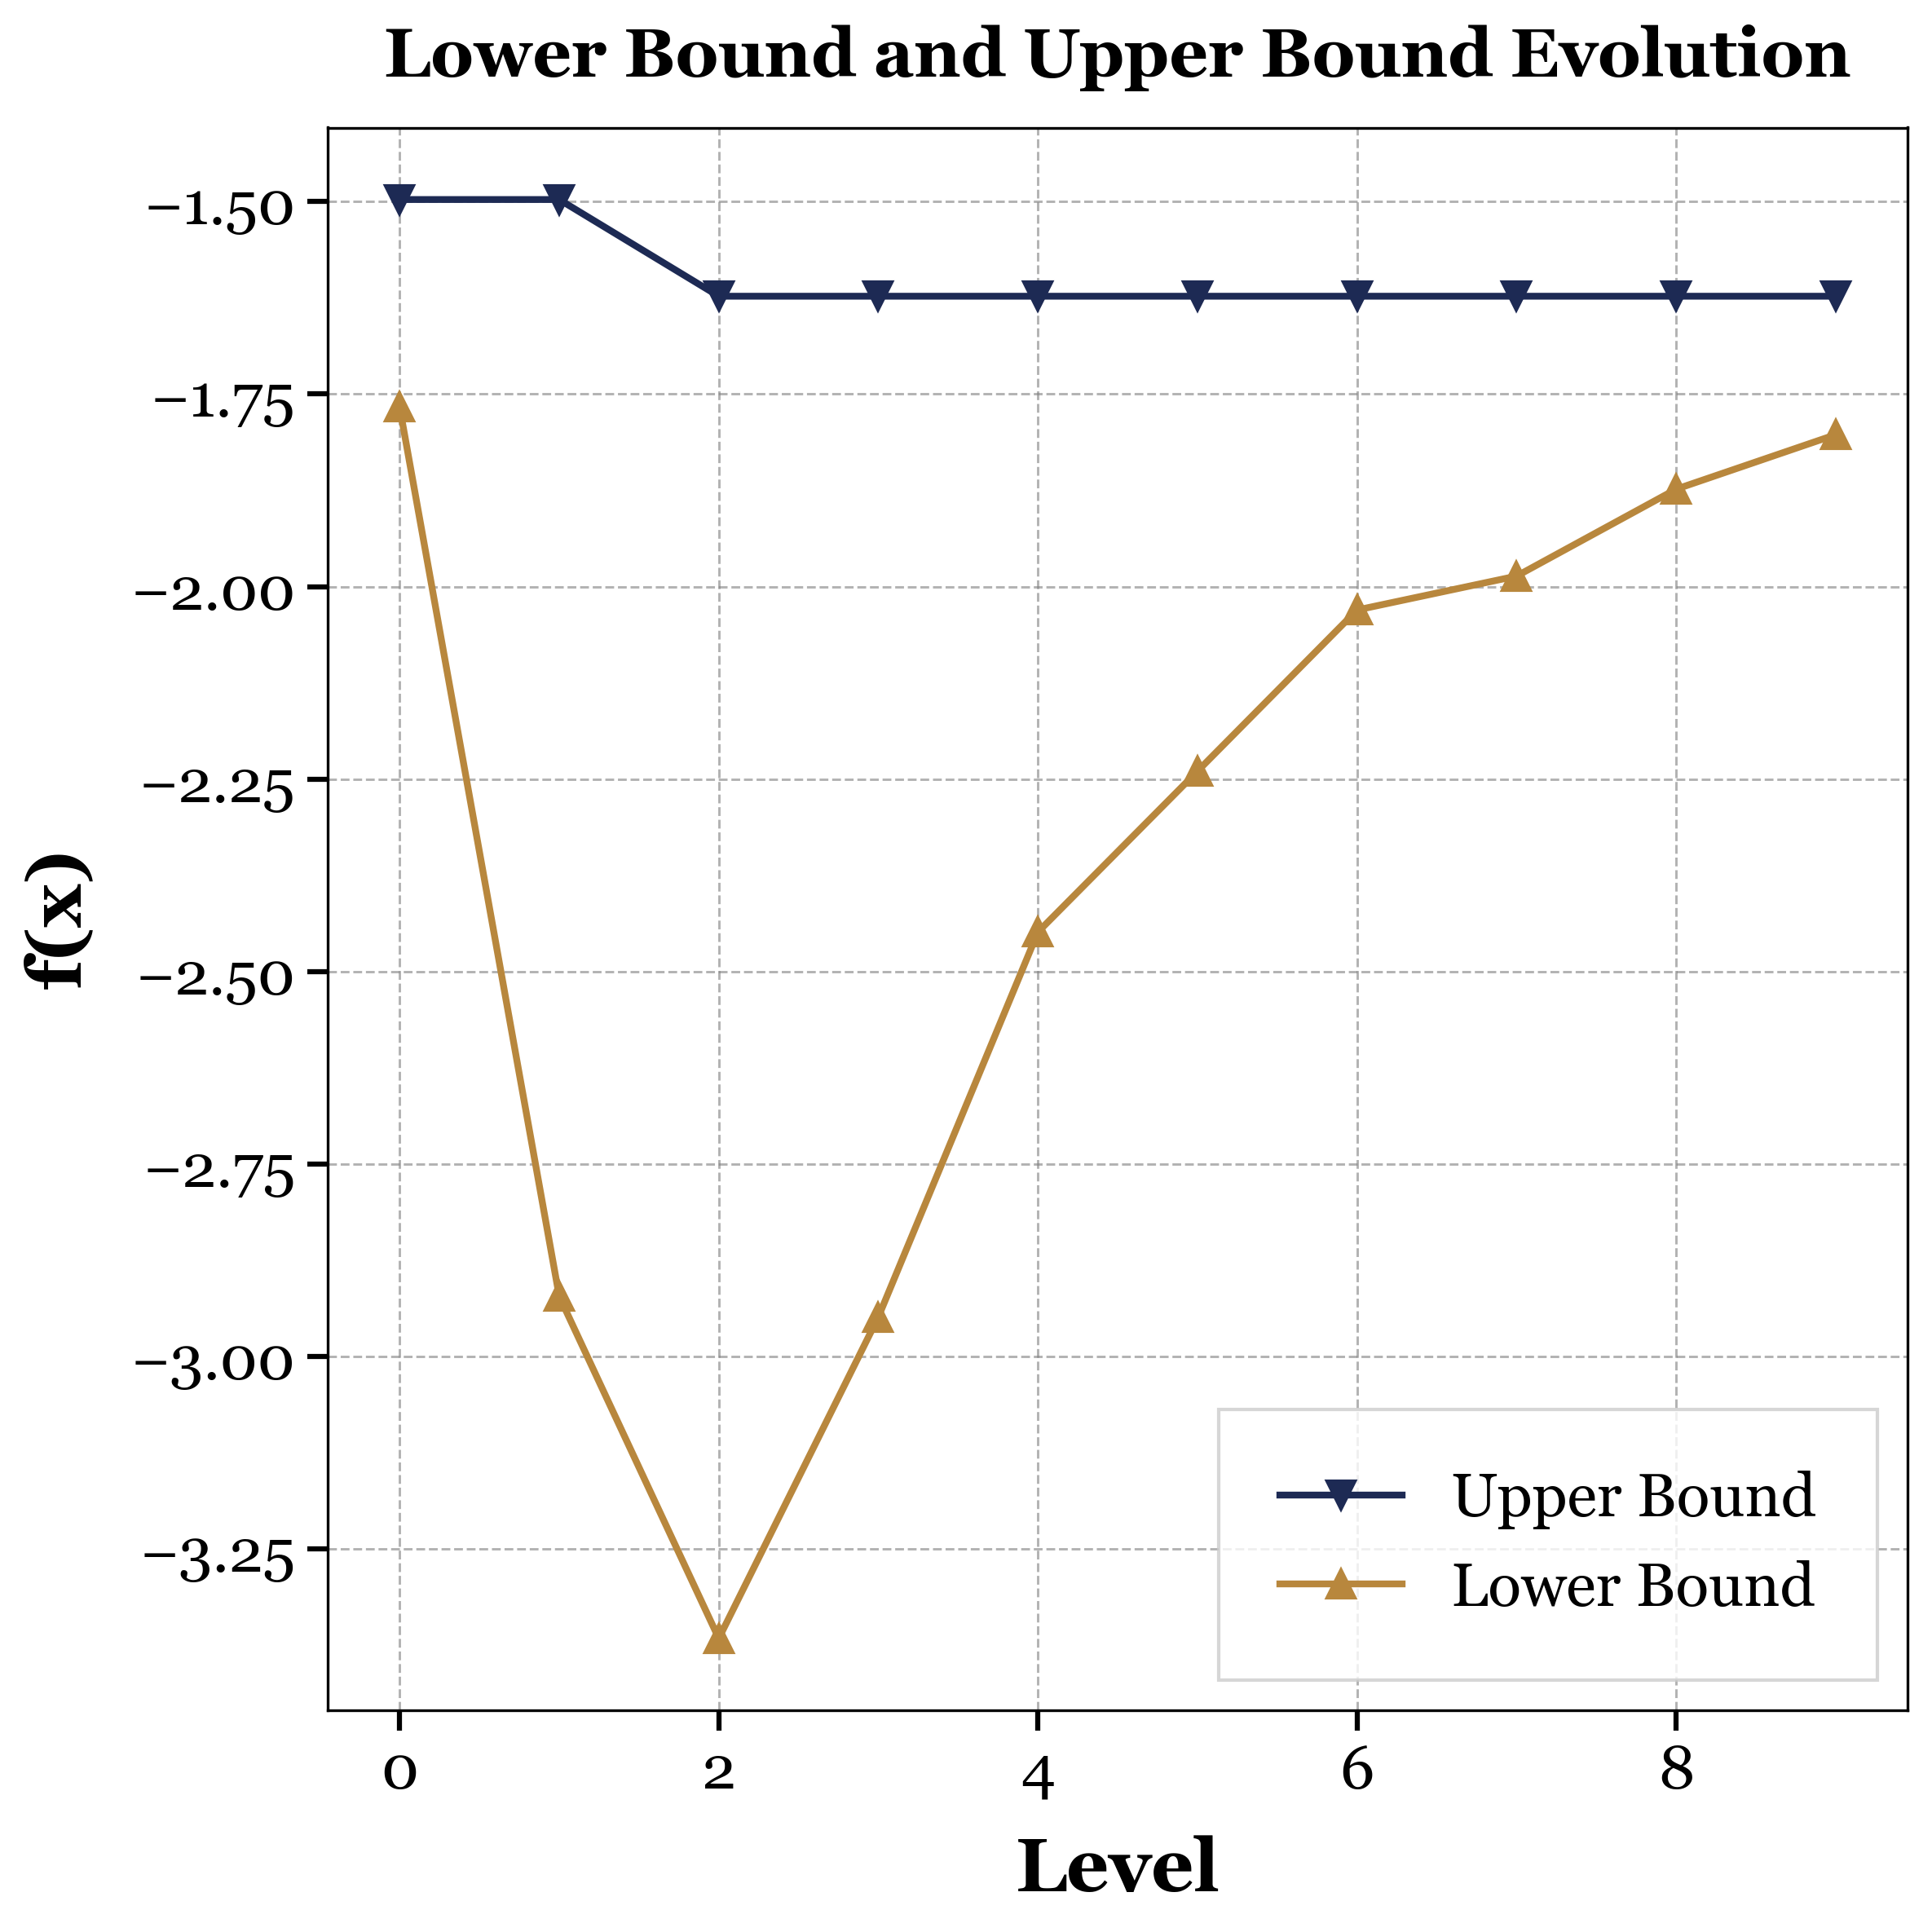

In [22]:
## Lowerbound and upperbound for lipschitz-informed underestimator
fig = plt.figure(figsize=(8, 8), dpi=300)
ax2 = fig.add_subplot(1, 1, 1)

marker_clr = '#EEAE40'
for level in bcp_solver_LC.Tree.keys():
    for node in bcp_solver_LC.Tree[level].values():
        shade1 = np.arange(node.bounds[0, 0], node.bounds[1, 0], 0.001)
        ax2.fill_between(
            shade1,
            node.bounds[1, 1],
            node.bounds[0, 1],
            facecolor=plt.cm.Greys(level / len(bcp_solver_LC.Tree.keys())),
            edgecolor='white',
            linewidth=0.4,
            alpha=0.8
        )
        ax2.scatter(
            node.x[:, 0],
            node.x[:, 1],
            marker='.',
            s=100,
            c=marker_clr,
            edgecolors='black',
            linewidth=0.75
        )

ax2.set_xlabel('$x_1$', fontsize=22, fontweight='bold', labelpad=10)
ax2.set_ylabel('$x_2$', fontsize=22, fontweight='bold', labelpad=10)
ax2.tick_params(axis='both', labelsize=18, width=1.5, length=6)
ax2.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
ax2.set_title('Search Space Branching and Sampling', fontsize=22, fontweight='bold', pad=15)
plt.tight_layout()

plt.show()

###-------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8,8), dpi=300)
ax = fig.add_subplot(1, 1, 1)

levels = range(len(bcp_solver_LC._lowerbound_hist))

ax.plot(
    levels, 
    bcp_solver_LC._upperbound_hist, 
    label='Upper Bound', 
    color= '#1d2a54', 
    marker='v', 
    markersize=8, 
    linewidth=2
)
ax.plot(
    levels, 
    bcp_solver_LC._lowerbound_hist, 
    label='Lower Bound', 
    color='#b8873d', 
    marker='^', 
    markersize=8, 
    linewidth=2
)
ax.set_xlabel('Level', fontsize=22, fontweight='bold', labelpad=10)
ax.set_ylabel('f(x)', fontsize=22, fontweight='bold', labelpad=10)

ax.tick_params(axis='both', labelsize=18, width=1.5, length=6)

ax.legend(
    fontsize=18, 
    frameon=True, 
    loc='lower right', 
    fancybox=False, 
    shadow=False, 
    borderpad=1
)

ax.grid(color='gray', linestyle='--', linewidth=0.7, alpha=0.6)
ax.set_title('Lower Bound and Upper Bound Evolution', fontsize=20, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()



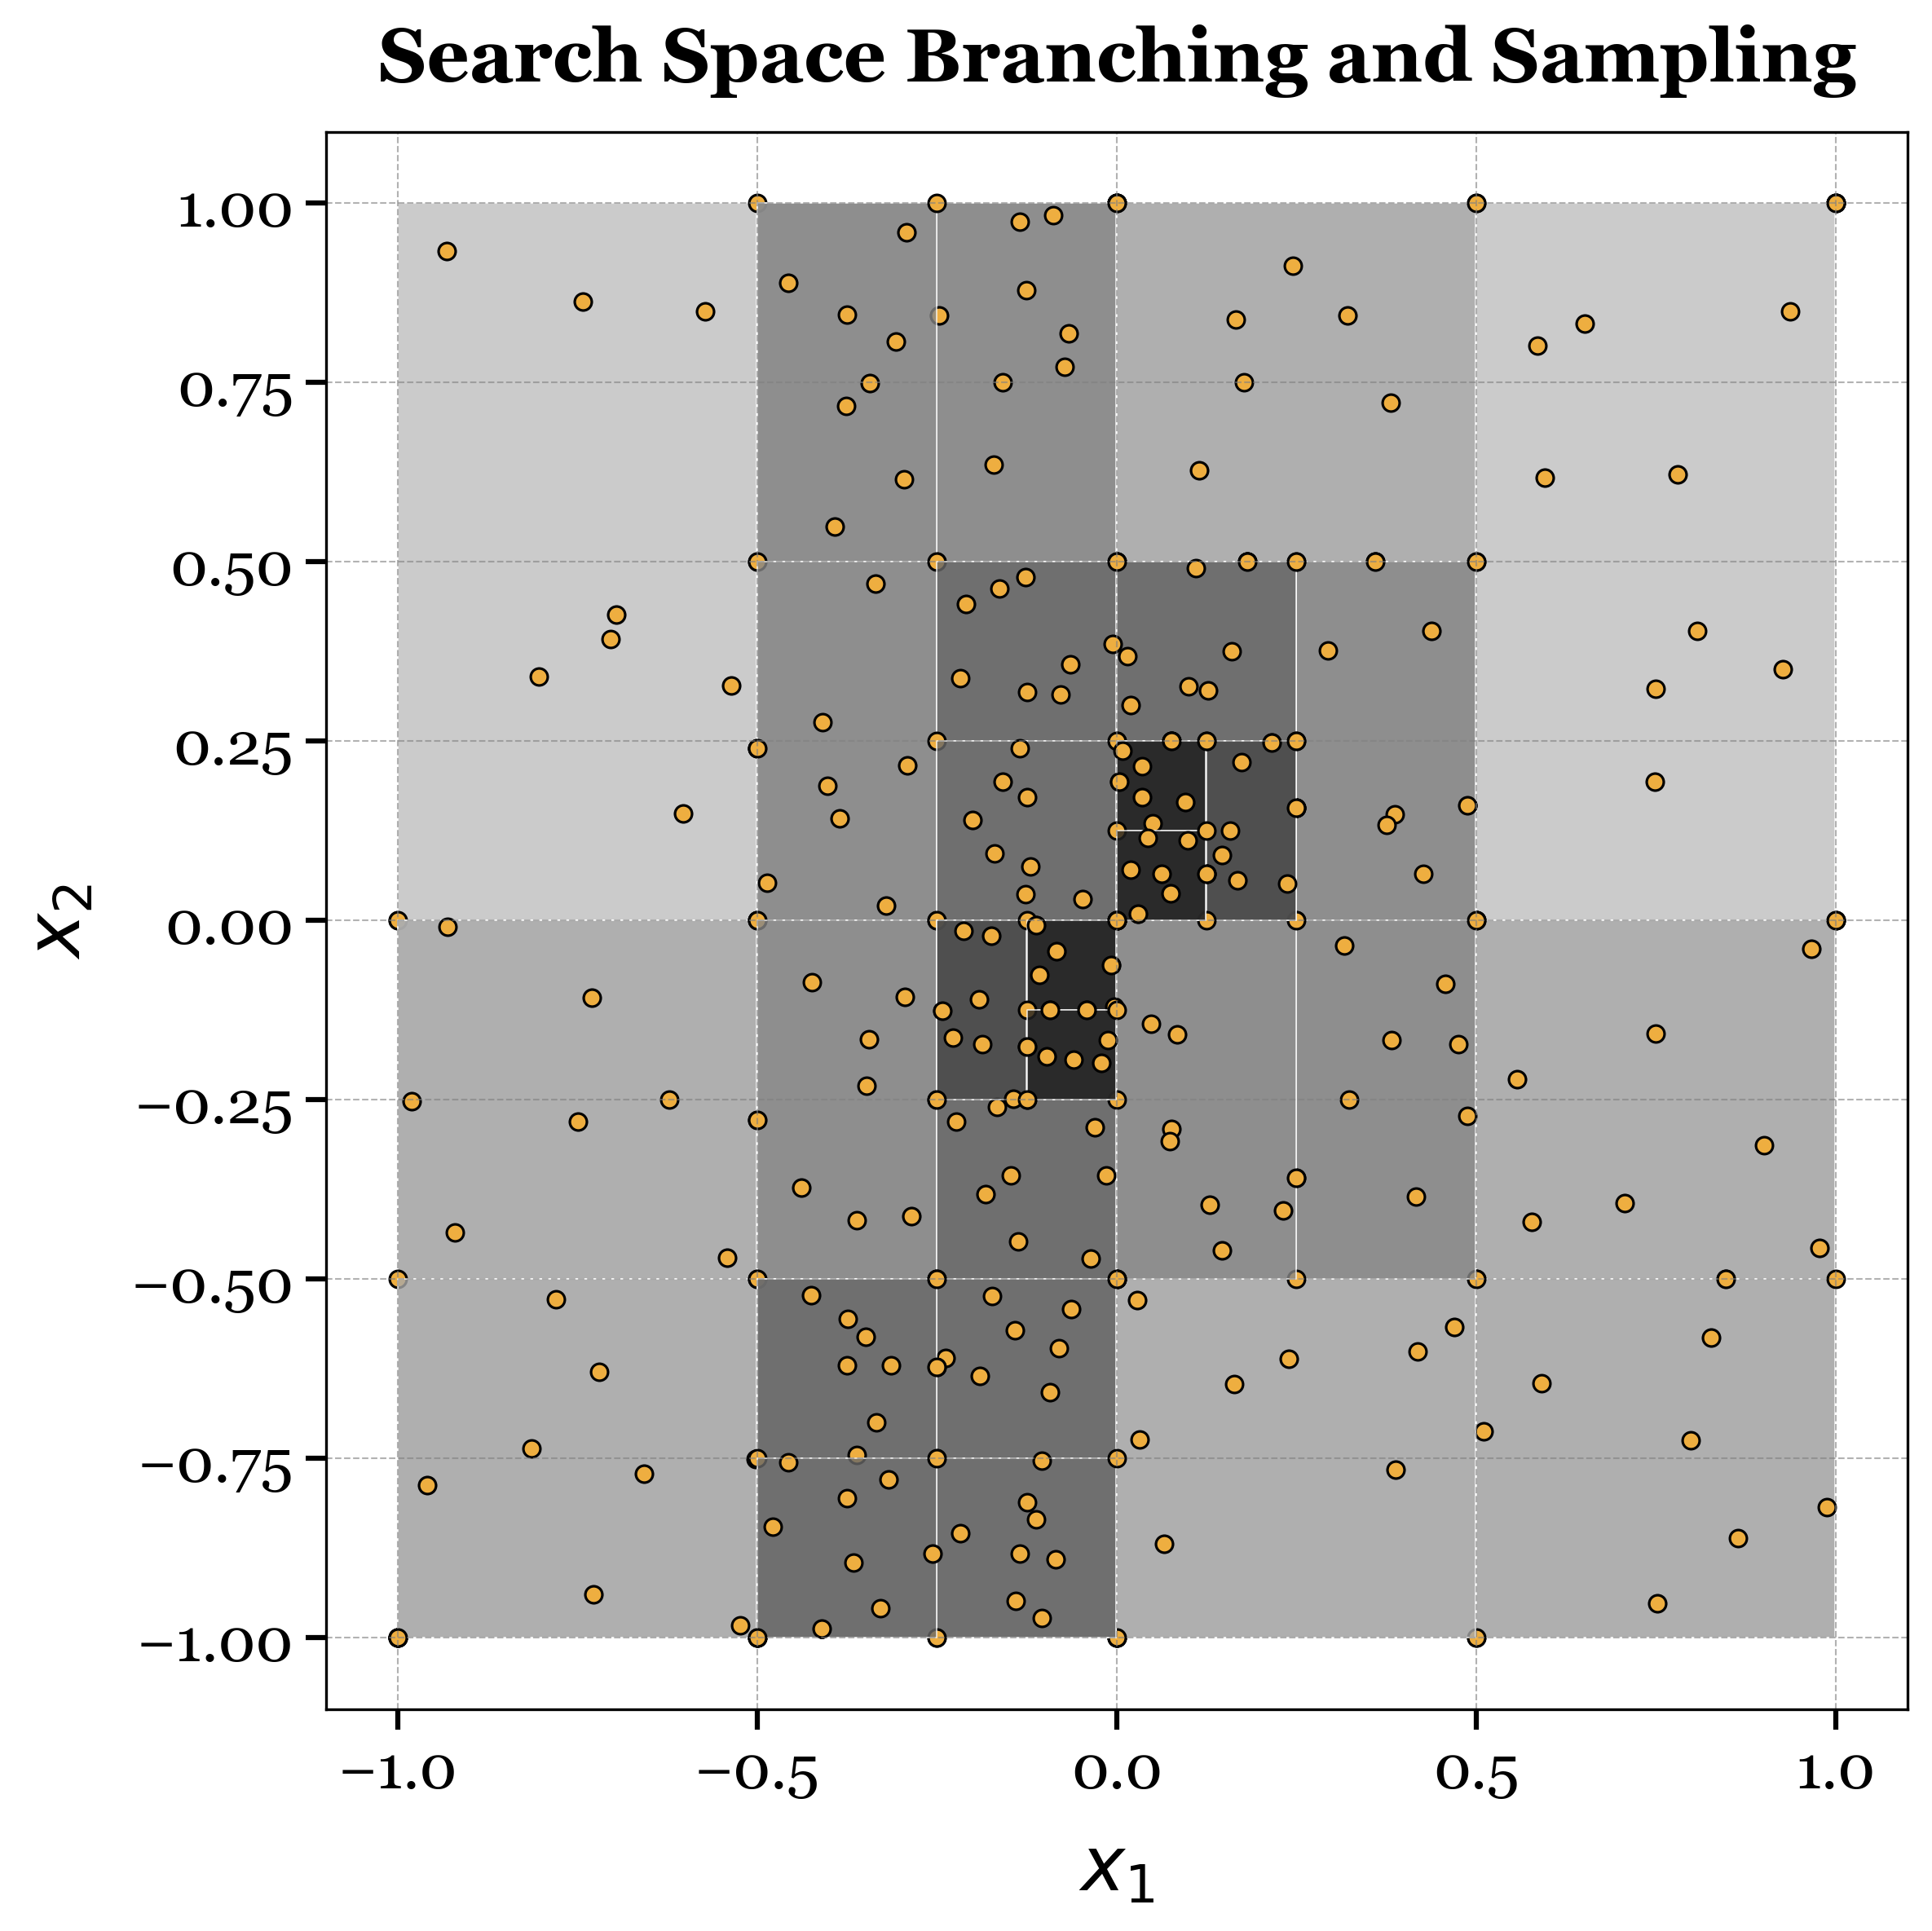

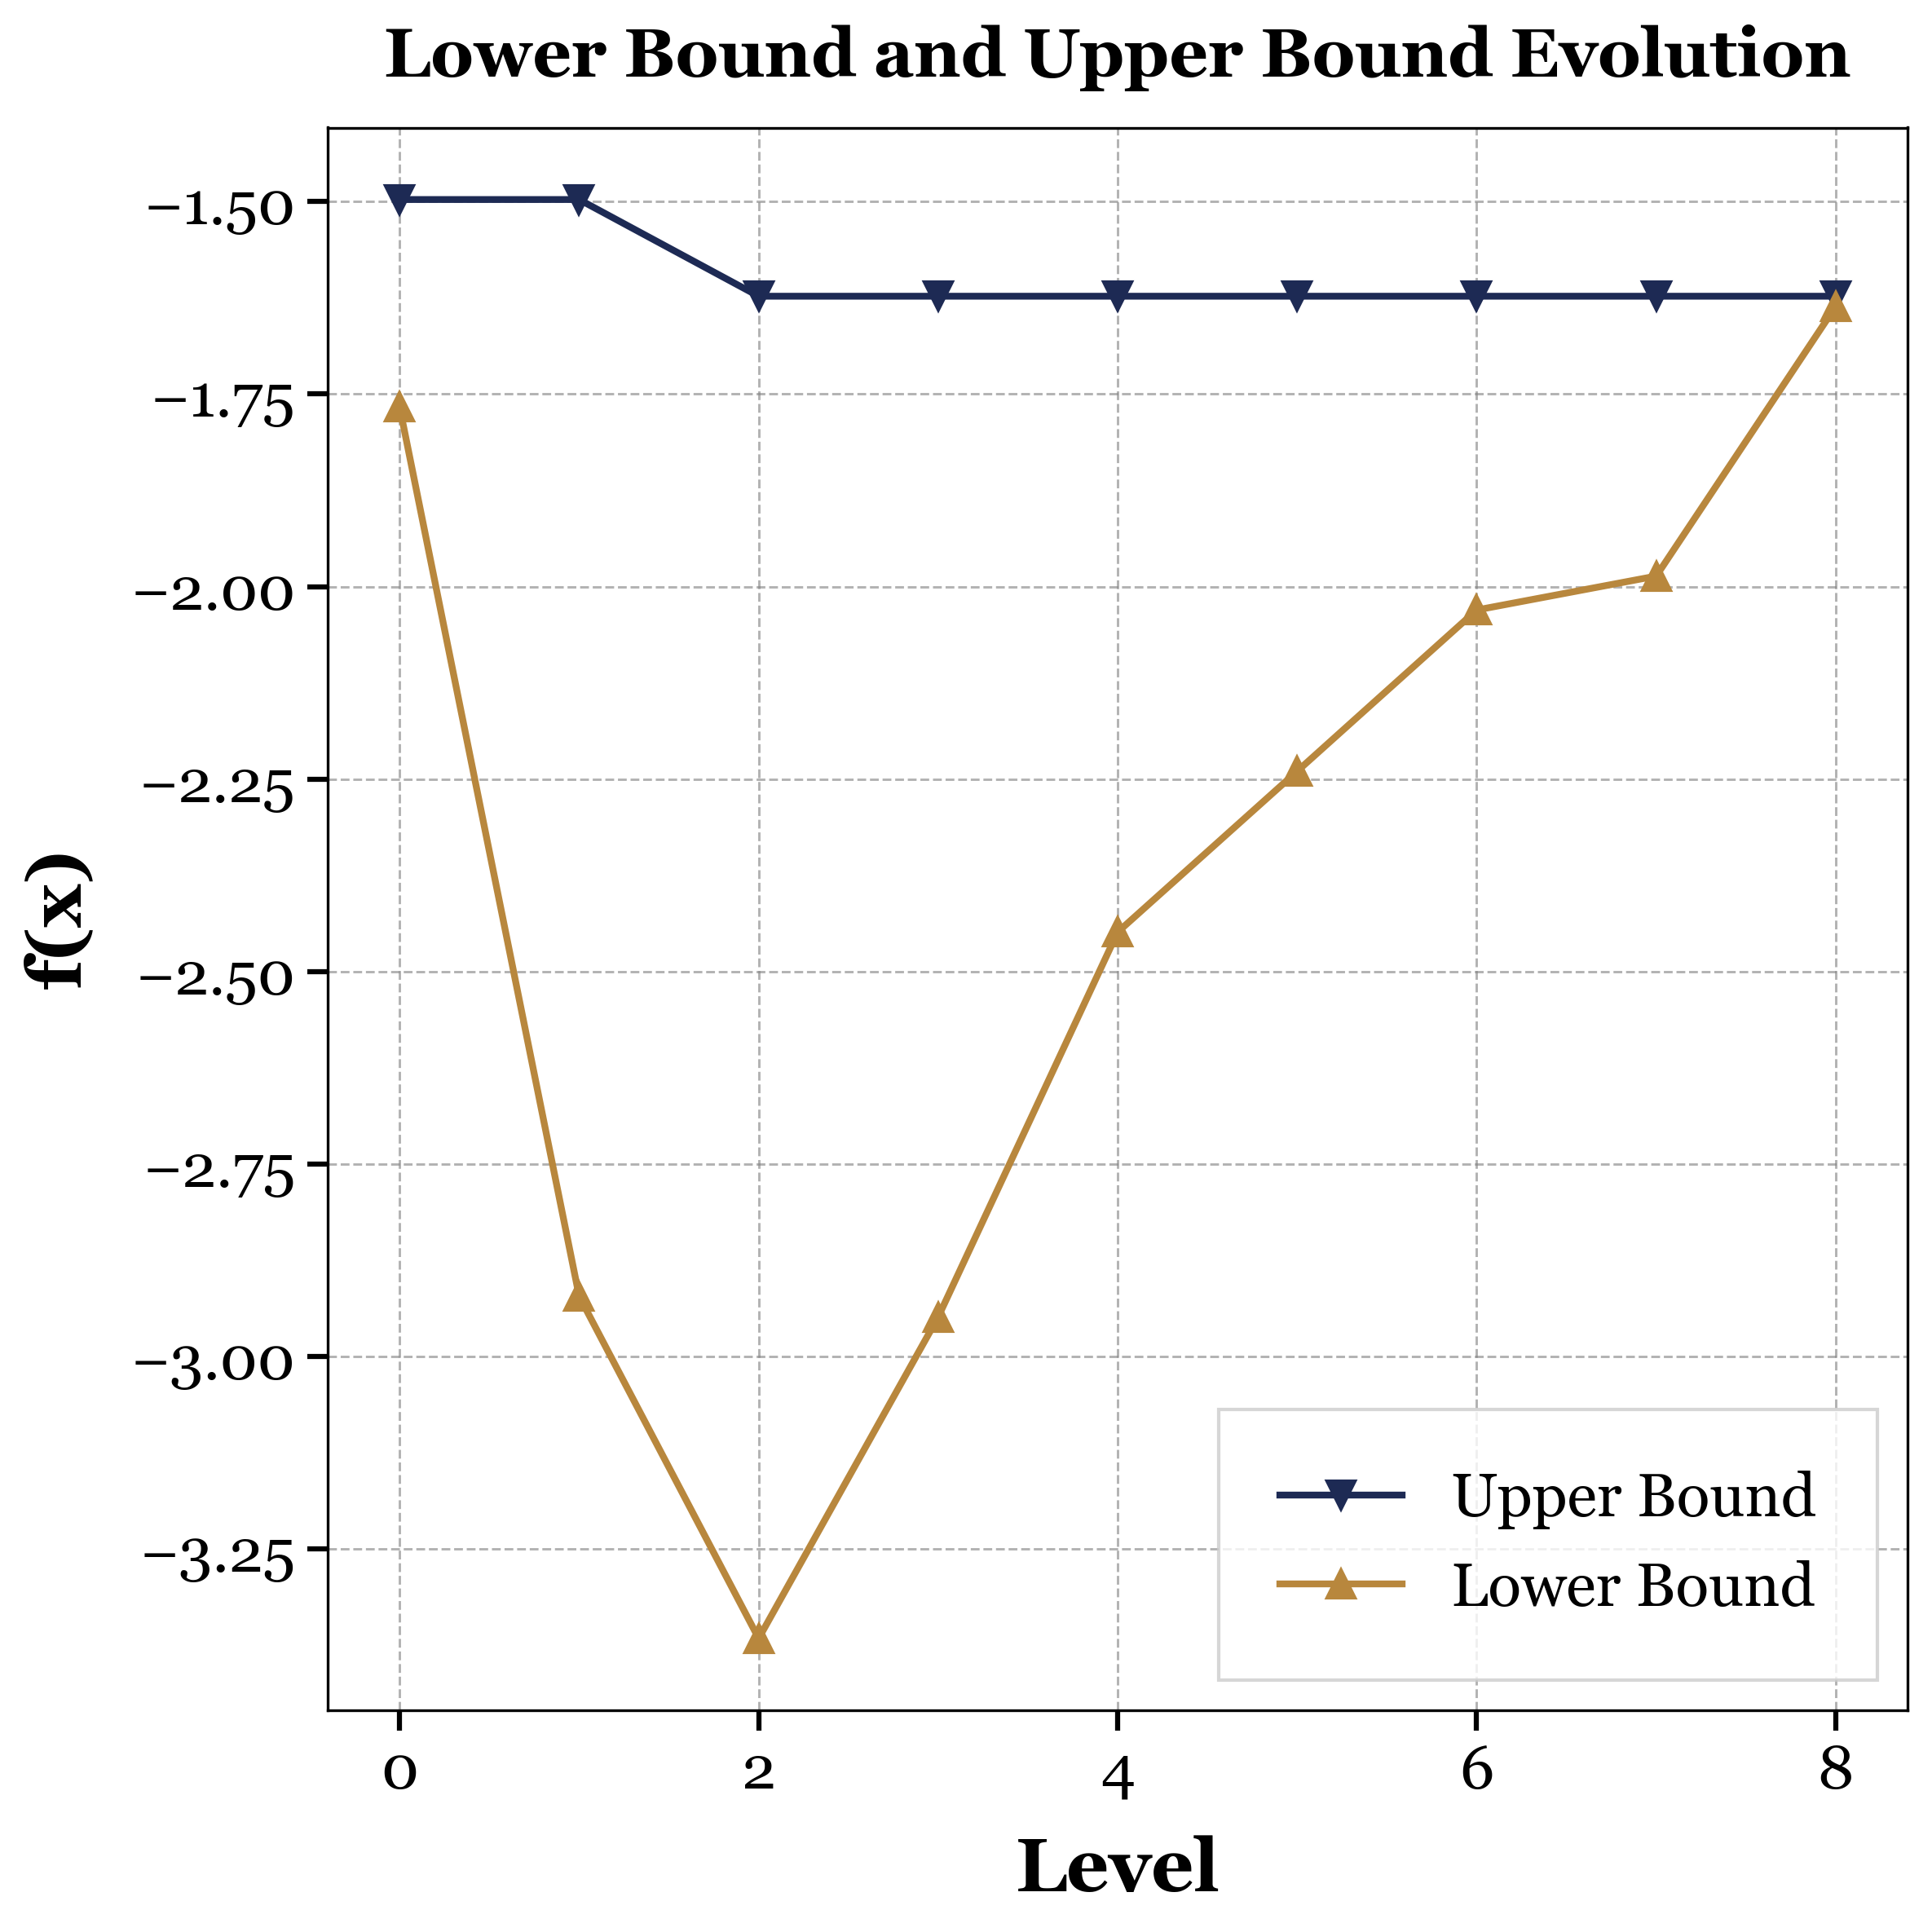

In [23]:
## Lowerbound and upperbound for lipschitz-informed underestimator
fig = plt.figure(figsize=(8, 8), dpi=300)
ax2 = fig.add_subplot(1, 1, 1)

marker_clr = '#EEAE40'
for level in bcp_solver_LC_IC.Tree.keys():
    for node in bcp_solver_LC_IC.Tree[level].values():
        shade1 = np.arange(node.bounds[0, 0], node.bounds[1, 0], 0.001)
        ax2.fill_between(
            shade1,
            node.bounds[1, 1],
            node.bounds[0, 1],
            facecolor=plt.cm.Greys(level / len(bcp_solver_LC_IC.Tree.keys())),
            edgecolor='white',
            linewidth=0.4,
            alpha=0.8
        )
        ax2.scatter(
            node.x[:, 0],
            node.x[:, 1],
            marker='.',
            s=100,
            c=marker_clr,
            edgecolors='black',
            linewidth=0.75
        )

ax2.set_xlabel('$x_1$', fontsize=22, fontweight='bold', labelpad=10)
ax2.set_ylabel('$x_2$', fontsize=22, fontweight='bold', labelpad=10)
ax2.tick_params(axis='both', labelsize=18, width=1.5, length=6)
ax2.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
ax2.set_title('Search Space Branching and Sampling', fontsize=22, fontweight='bold', pad=15)
plt.tight_layout()

plt.show()

###-------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8,8), dpi=300)
ax = fig.add_subplot(1, 1, 1)

levels = range(len(bcp_solver_LC_IC._lowerbound_hist))

ax.plot(
    levels, 
    bcp_solver_LC_IC._upperbound_hist, 
    label='Upper Bound', 
    color= '#1d2a54', 
    marker='v', 
    markersize=8, 
    linewidth=2
)
ax.plot(
    levels, 
    bcp_solver_LC_IC._lowerbound_hist, 
    label='Lower Bound', 
    color='#b8873d', 
    marker='^', 
    markersize=8, 
    linewidth=2
)
ax.set_xlabel('Level', fontsize=22, fontweight='bold', labelpad=10)
ax.set_ylabel('f(x)', fontsize=22, fontweight='bold', labelpad=10)

ax.tick_params(axis='both', labelsize=18, width=1.5, length=6)

ax.legend(
    fontsize=18, 
    frameon=True, 
    loc='lower right', 
    fancybox=False, 
    shadow=False, 
    borderpad=1
)

ax.grid(color='gray', linestyle='--', linewidth=0.7, alpha=0.6)
ax.set_title('Lower Bound and Upper Bound Evolution', fontsize=20, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()



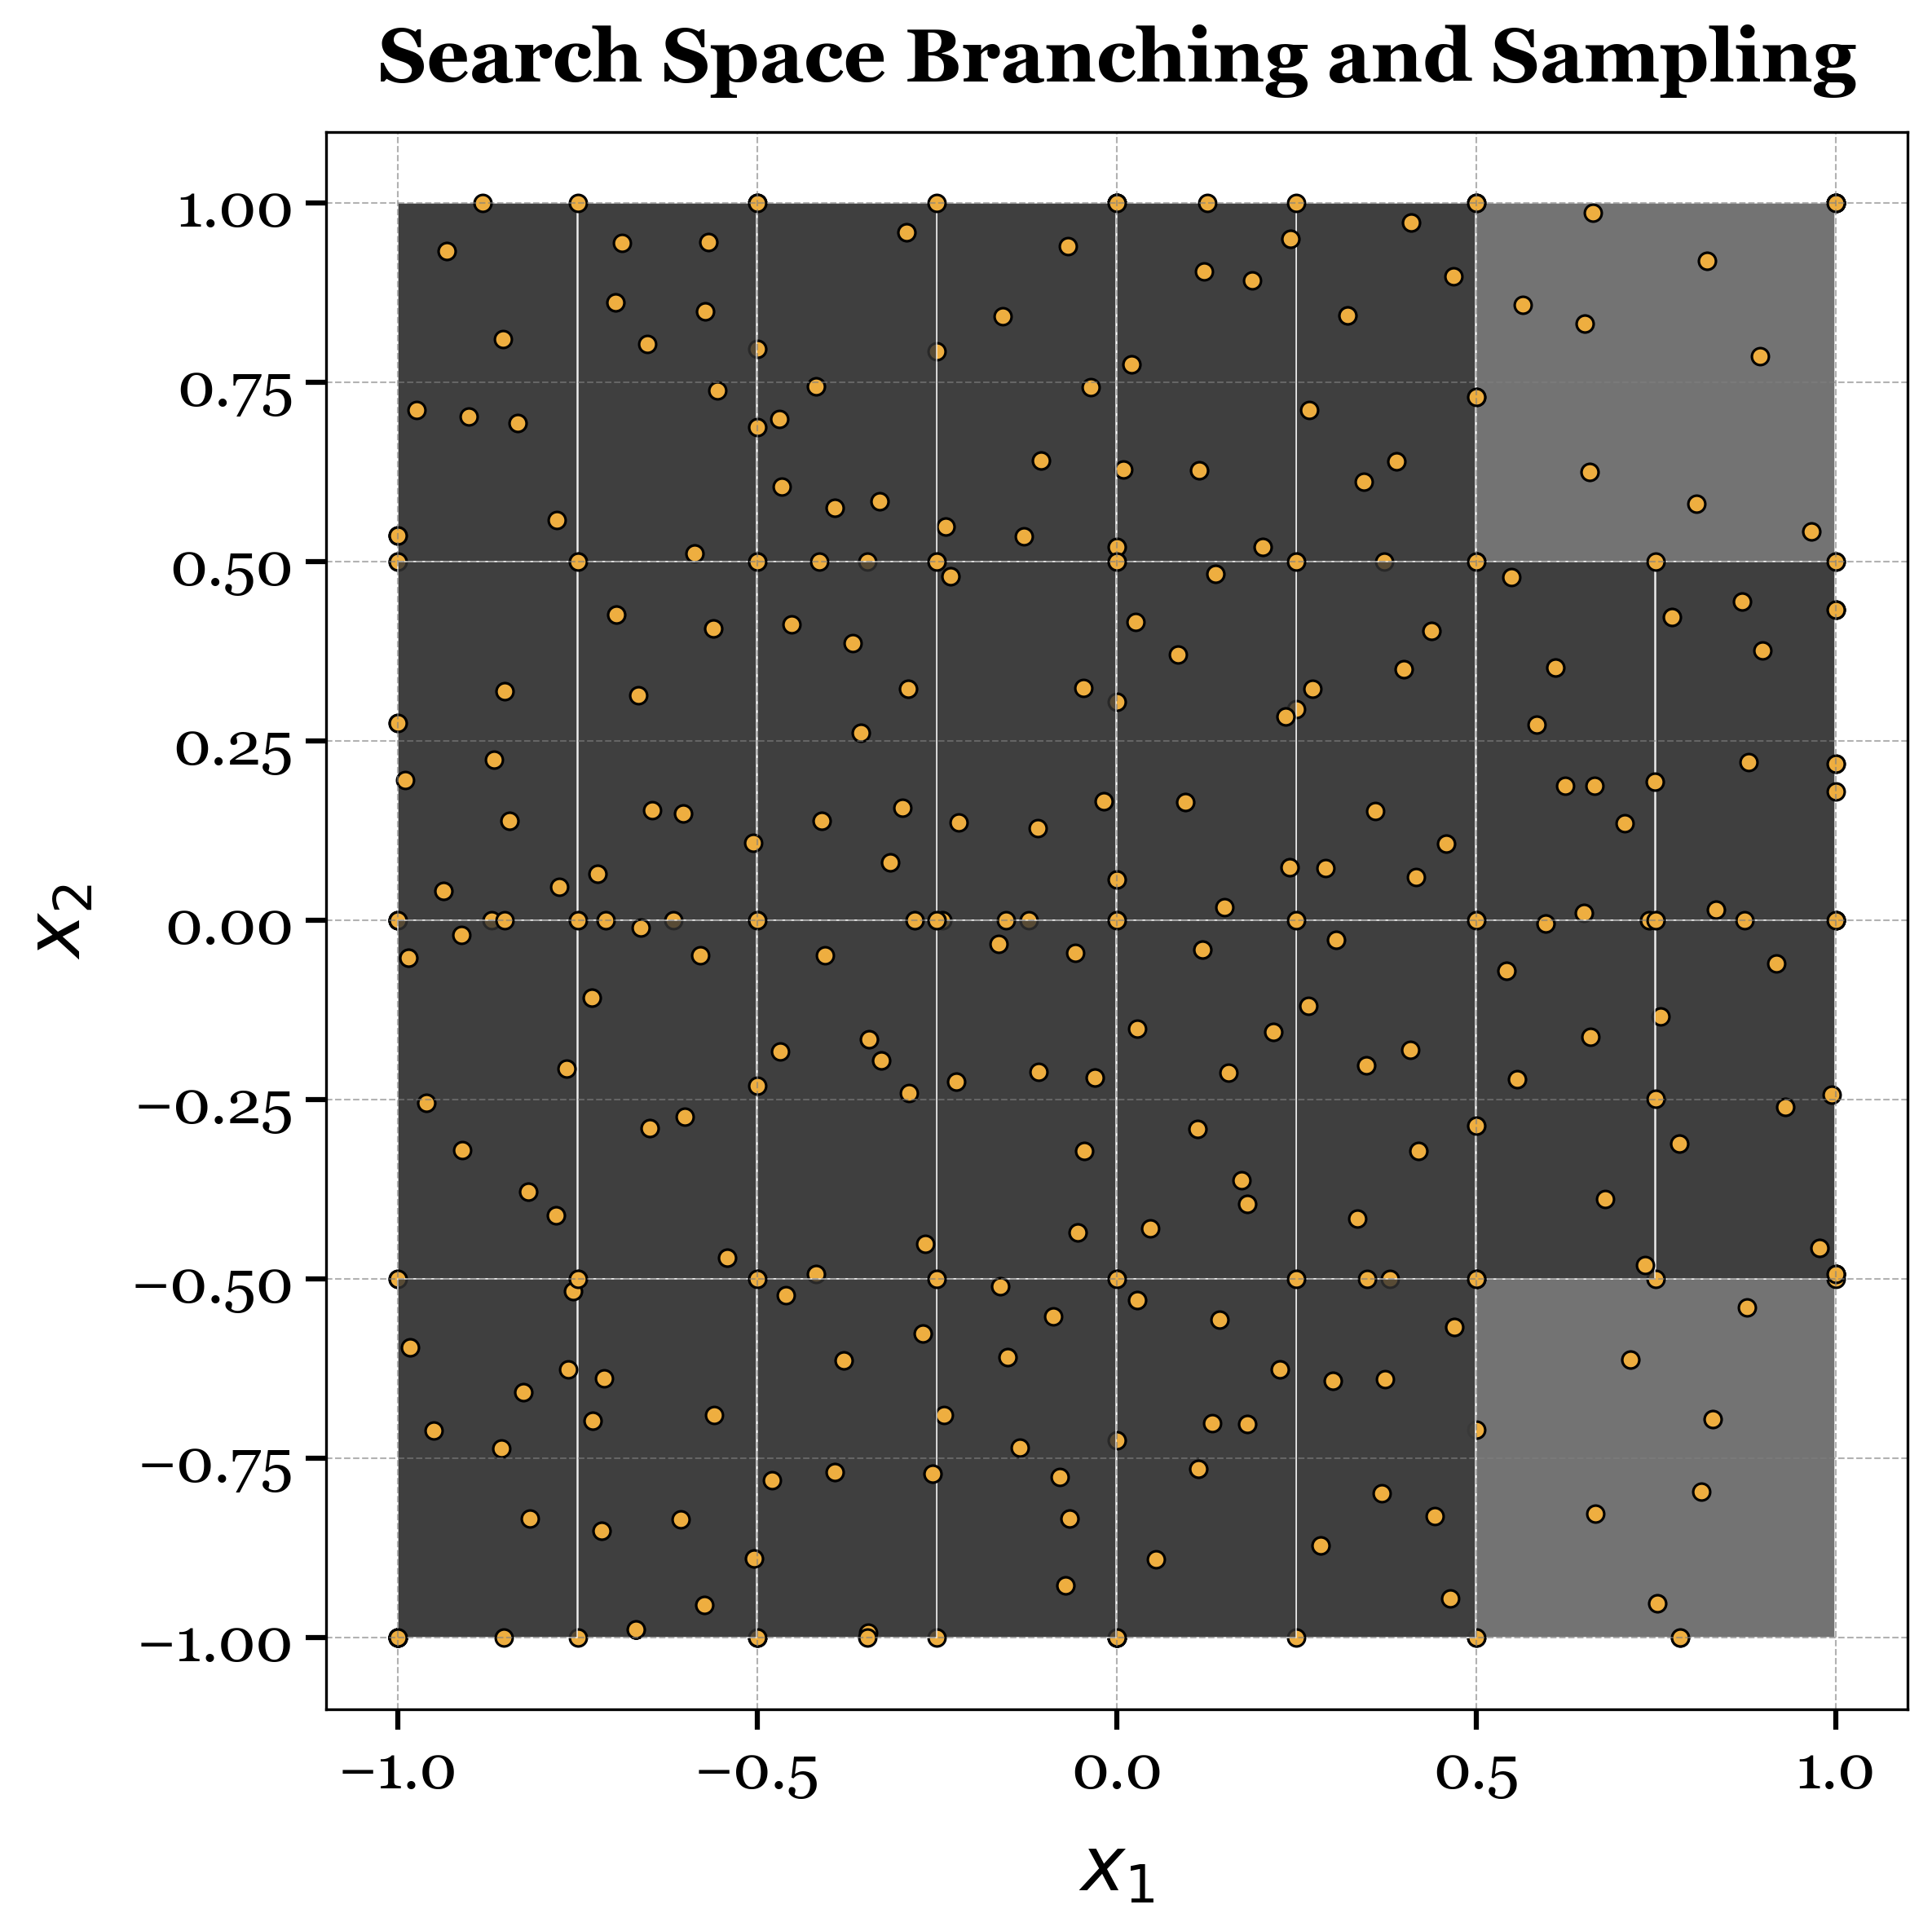

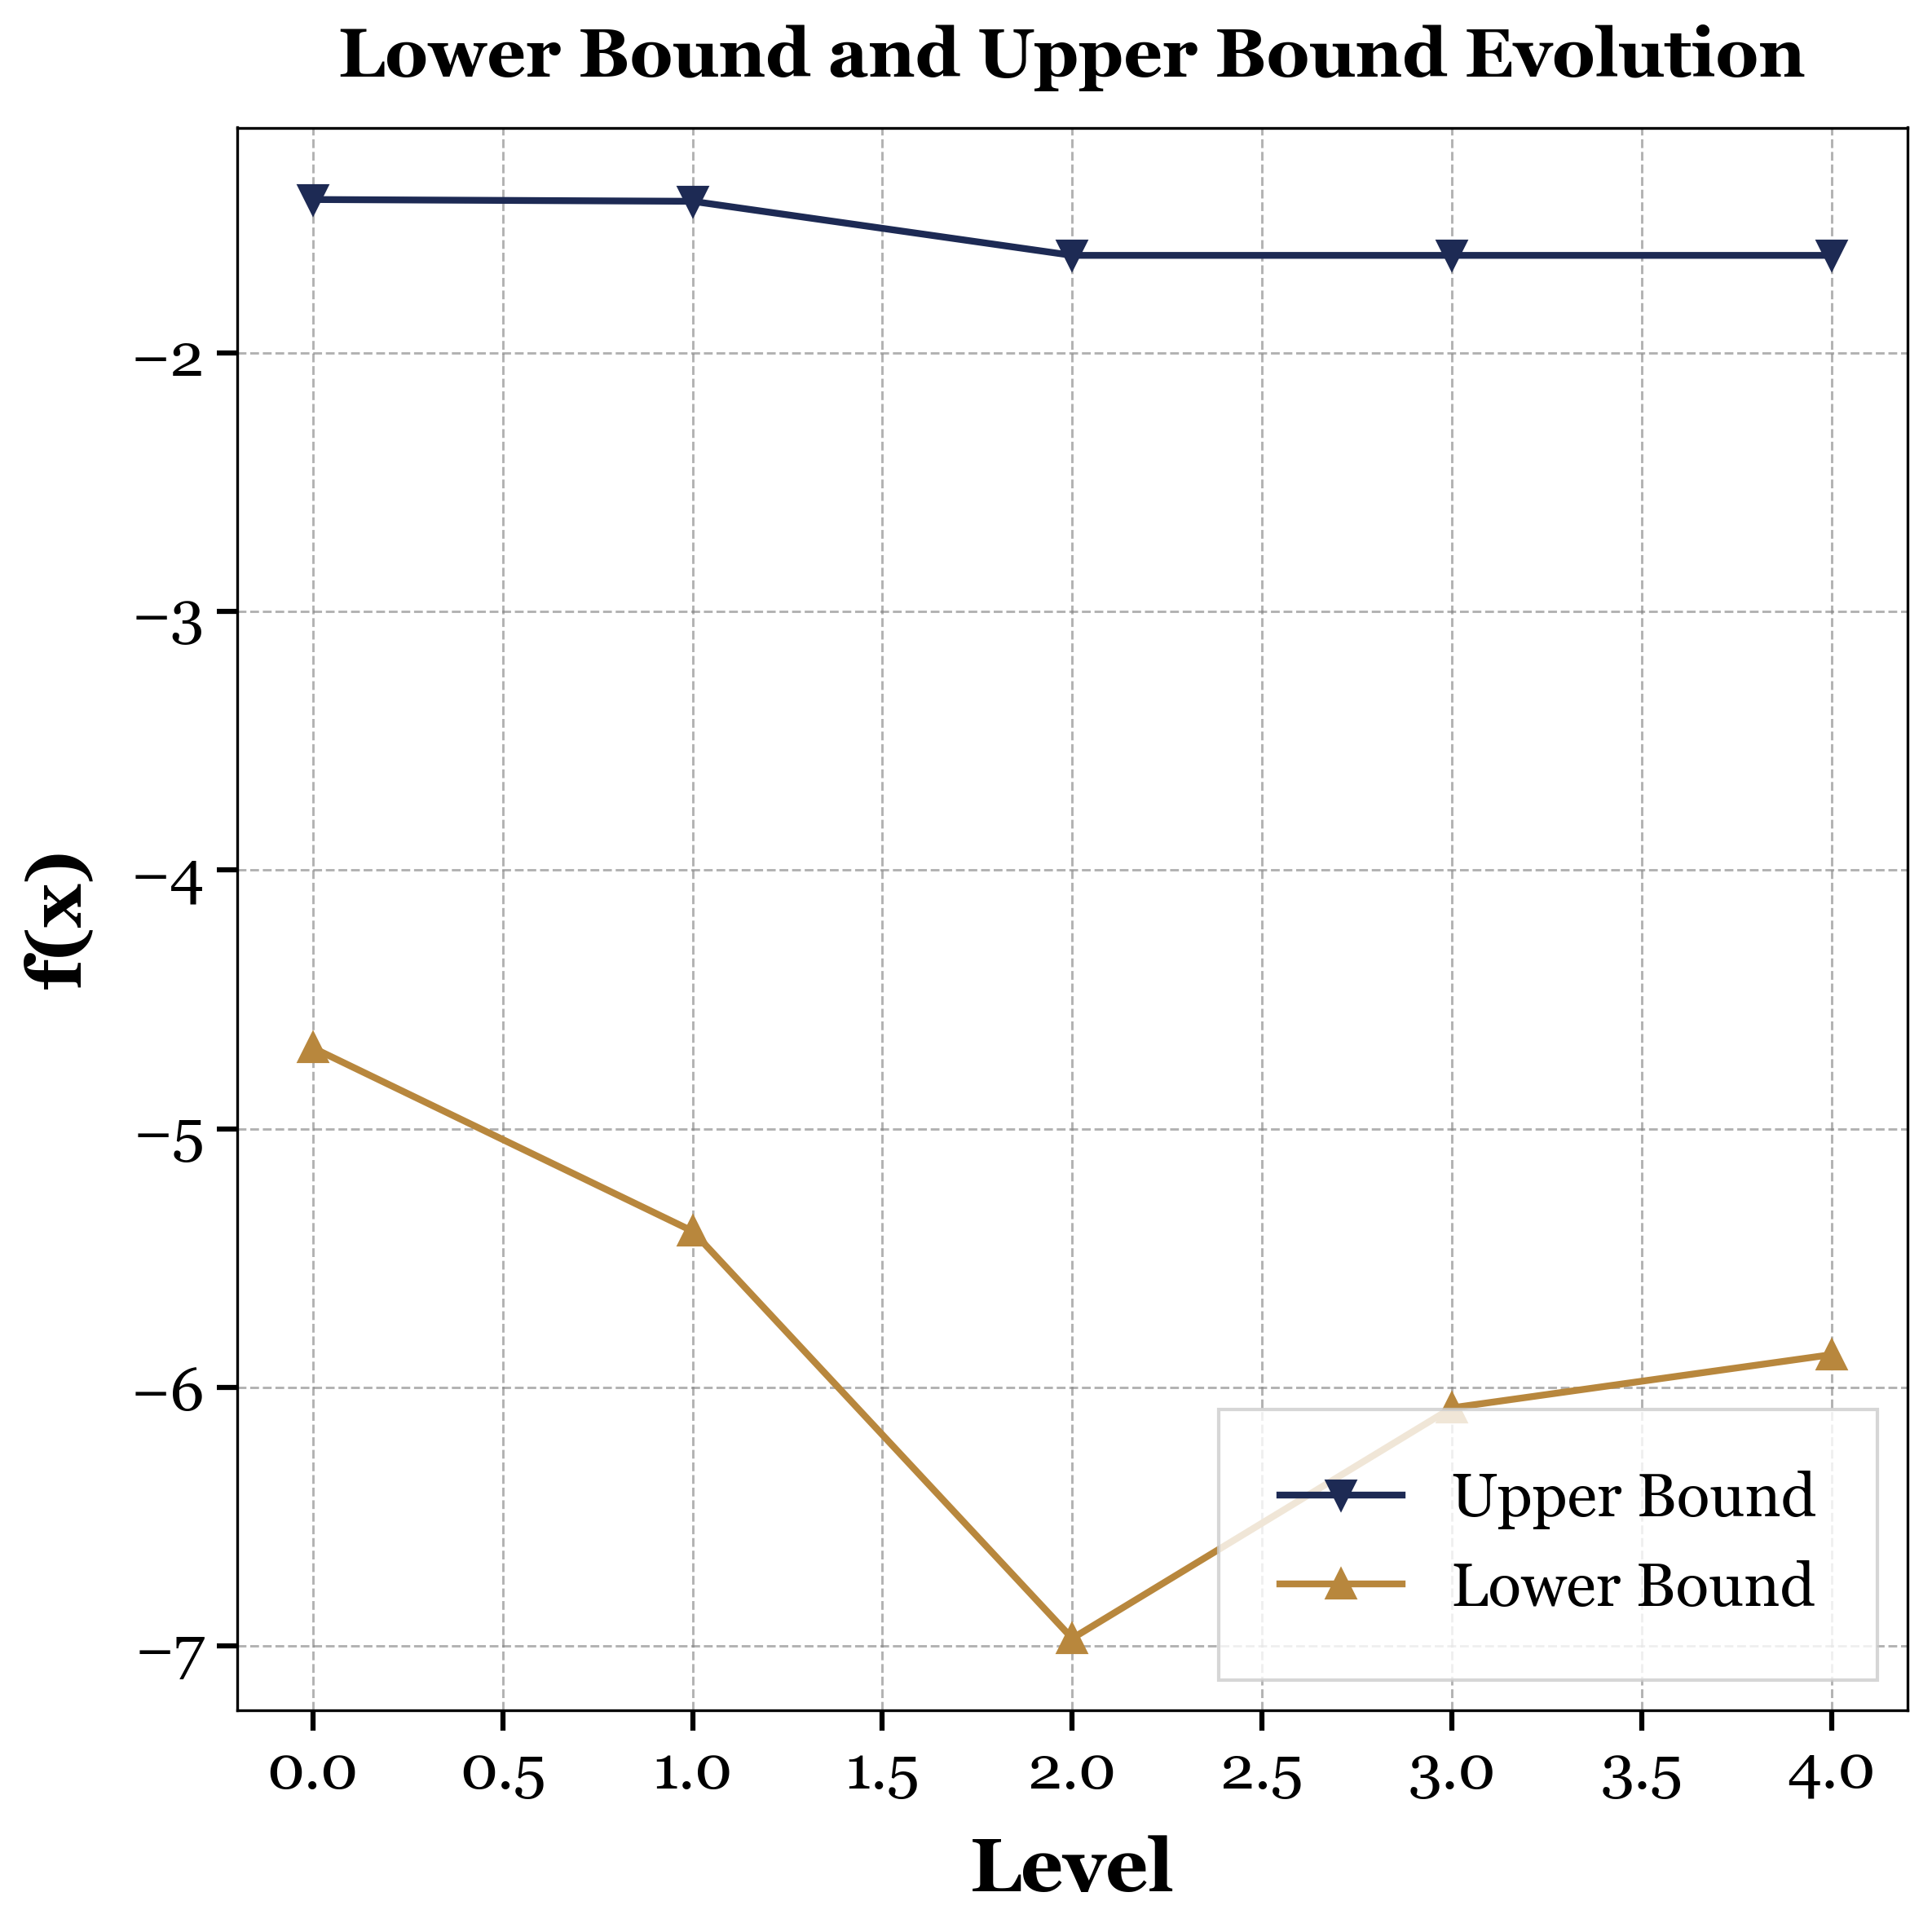

In [24]:
## Lowerbound and upperbound for lipschitz-informed underestimator
fig = plt.figure(figsize=(8, 8), dpi=300)
ax2 = fig.add_subplot(1, 1, 1)

marker_clr = '#EEAE40'
for level in bcp_solver_LC_bound.Tree.keys():
    for node in bcp_solver_LC_bound.Tree[level].values():
        shade1 = np.arange(node.bounds[0, 0], node.bounds[1, 0], 0.001)
        ax2.fill_between(
            shade1,
            node.bounds[1, 1],
            node.bounds[0, 1],
            facecolor=plt.cm.Greys(level / len(bcp_solver_LC_bound.Tree.keys())),
            edgecolor='white',
            linewidth=0.4,
            alpha=0.8
        )
        ax2.scatter(
            node.x[:, 0],
            node.x[:, 1],
            marker='.',
            s=100,
            c=marker_clr,
            edgecolors='black',
            linewidth=0.75
        )

ax2.set_xlabel('$x_1$', fontsize=22, fontweight='bold', labelpad=10)
ax2.set_ylabel('$x_2$', fontsize=22, fontweight='bold', labelpad=10)
ax2.tick_params(axis='both', labelsize=18, width=1.5, length=6)
ax2.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
ax2.set_title('Search Space Branching and Sampling', fontsize=22, fontweight='bold', pad=15)
plt.tight_layout()

plt.show()

###-------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8,8), dpi=300)
ax = fig.add_subplot(1, 1, 1)

levels = range(len(bcp_solver_LC_bound._lowerbound_hist))

ax.plot(
    levels, 
    bcp_solver_LC_bound._upperbound_hist, 
    label='Upper Bound', 
    color= '#1d2a54', 
    marker='v', 
    markersize=8, 
    linewidth=2
)
ax.plot(
    levels, 
    bcp_solver_LC_bound._lowerbound_hist, 
    label='Lower Bound', 
    color='#b8873d', 
    marker='^', 
    markersize=8, 
    linewidth=2
)
ax.set_xlabel('Level', fontsize=22, fontweight='bold', labelpad=10)
ax.set_ylabel('f(x)', fontsize=22, fontweight='bold', labelpad=10)

ax.tick_params(axis='both', labelsize=18, width=1.5, length=6)

ax.legend(
    fontsize=18, 
    frameon=True, 
    loc='lower right', 
    fancybox=False, 
    shadow=False, 
    borderpad=1
)

ax.grid(color='gray', linestyle='--', linewidth=0.7, alpha=0.6)
ax.set_title('Lower Bound and Upper Bound Evolution', fontsize=20, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()



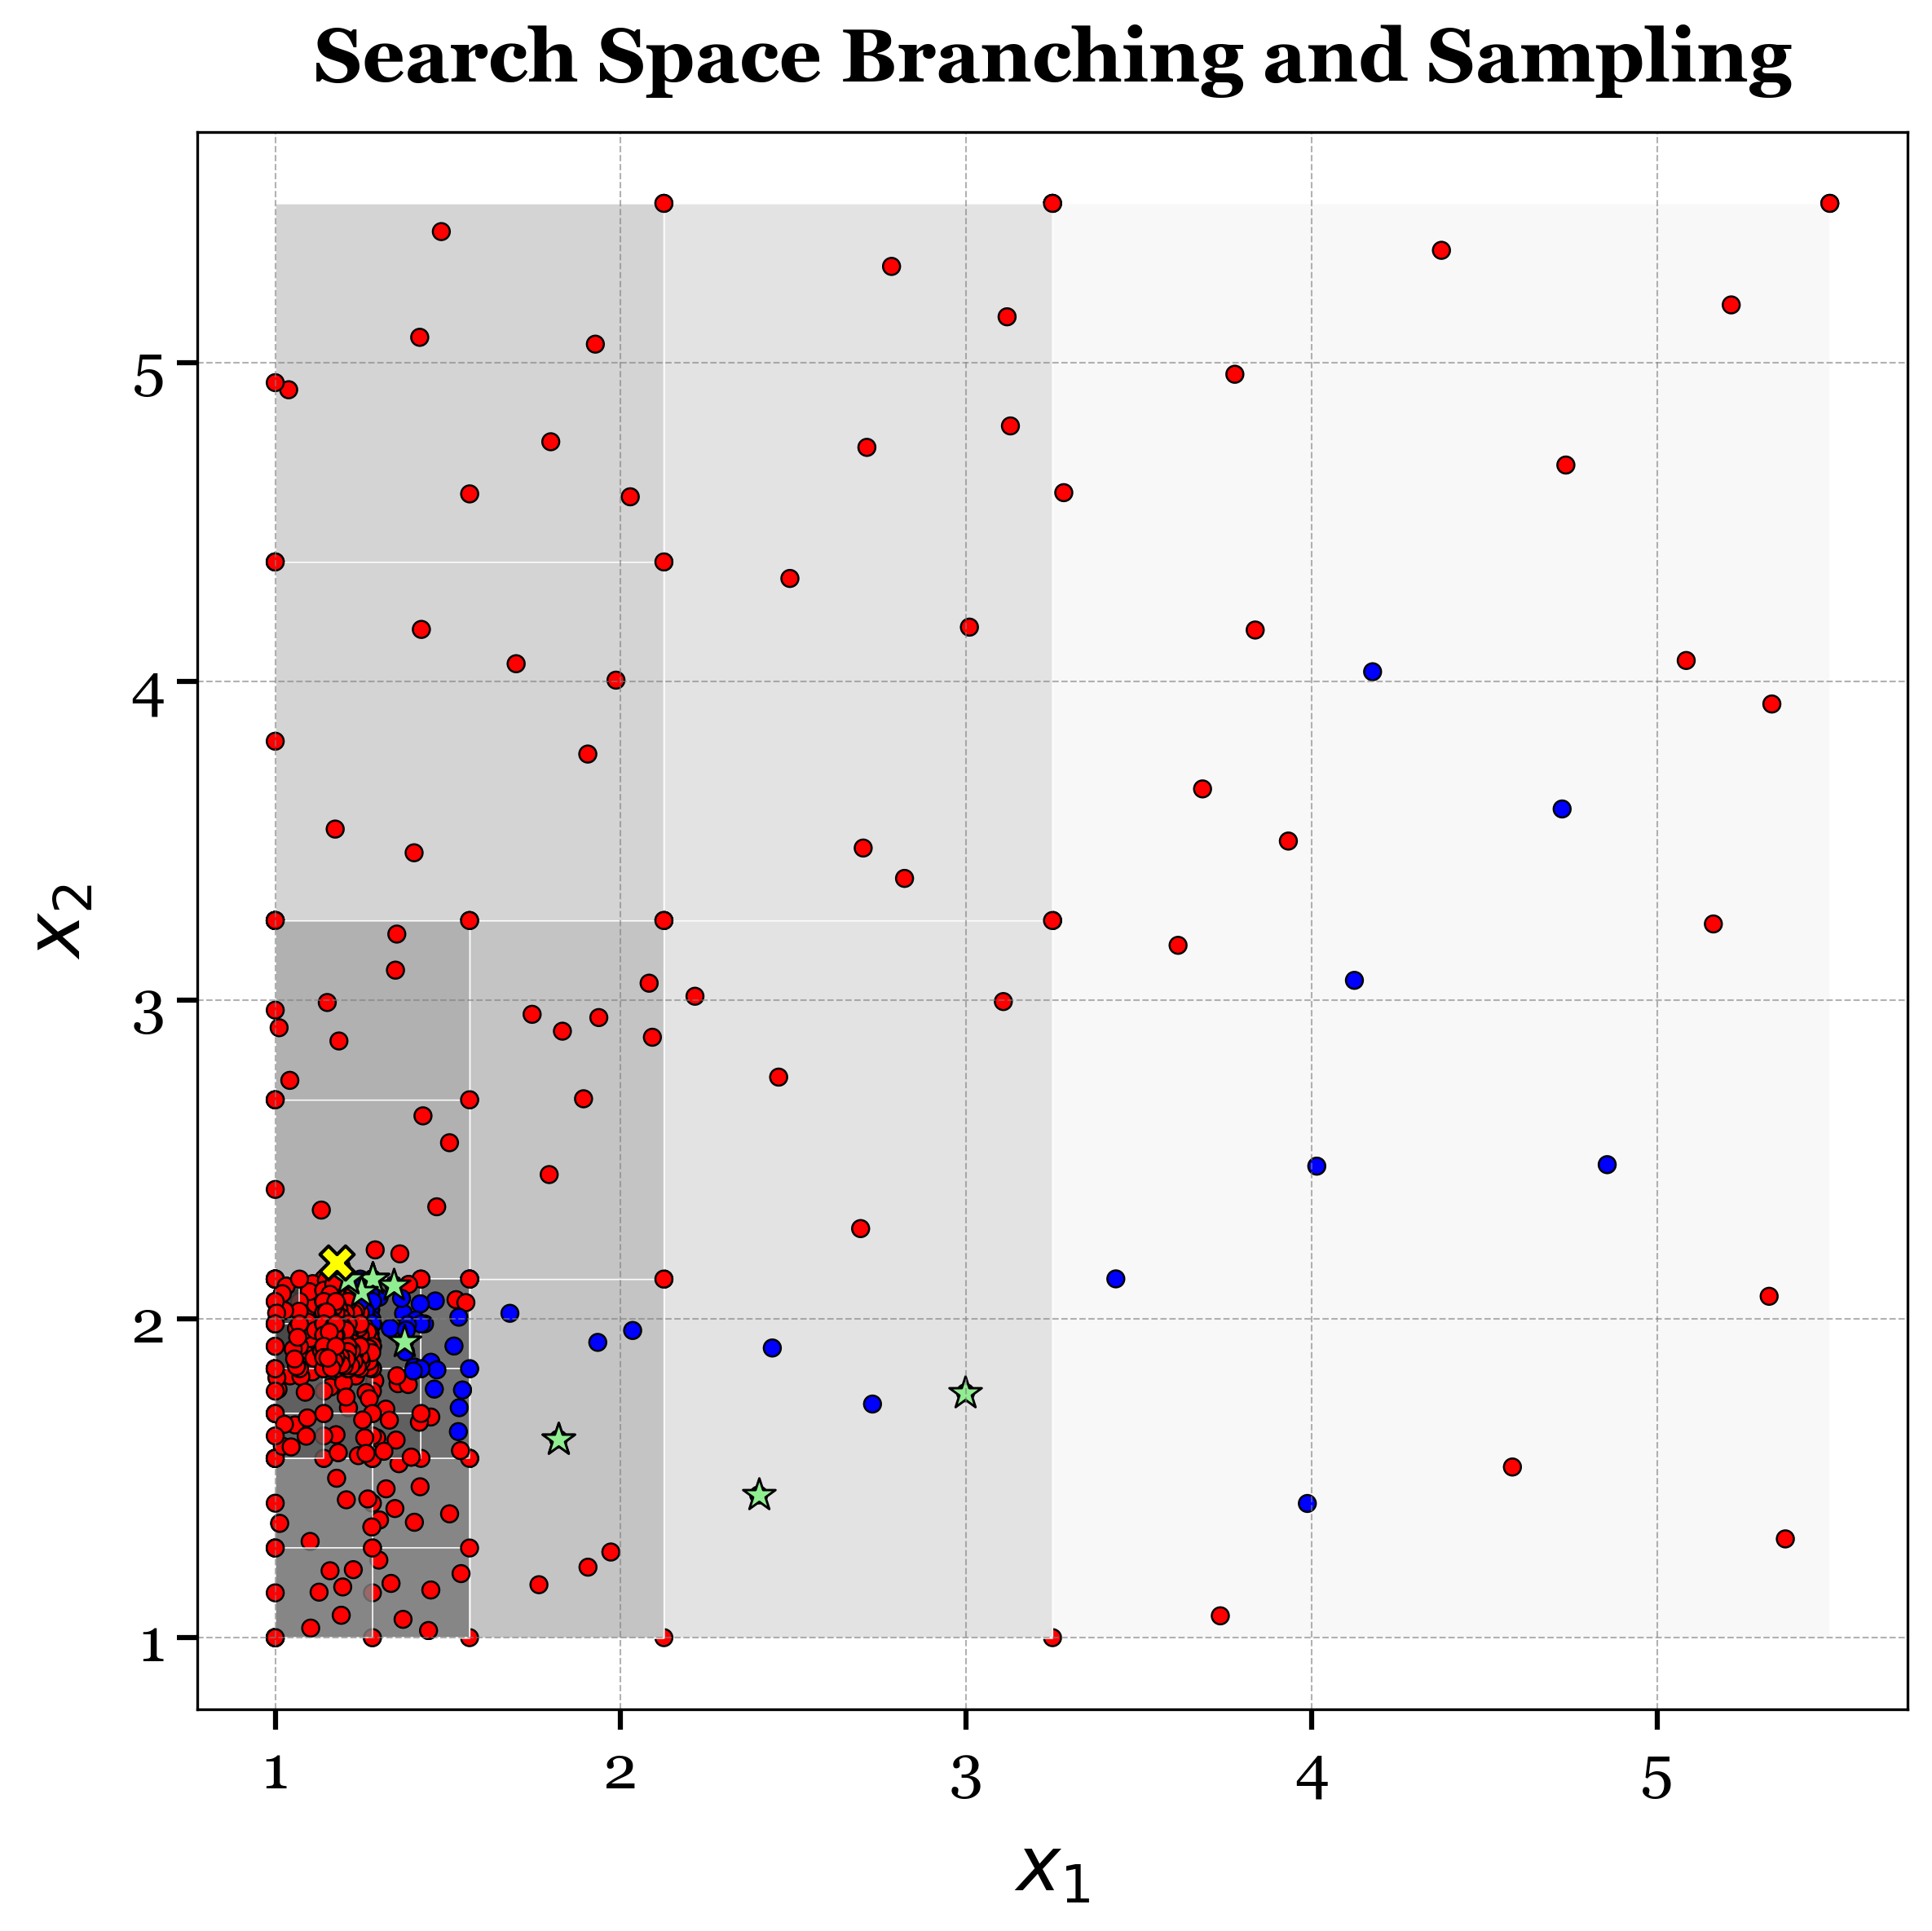

In [25]:
## Visualize the branch-and-bound process
fig = plt.figure(figsize=(8, 8), dpi=300)
ax2 = fig.add_subplot(1, 1, 1)

for level in blk_solver.Tree.keys():
    for node in blk_solver.Tree[level].values():
        shade1 = np.arange(node.bounds[0, 0], node.bounds[1, 0], 0.001)
        ax2.fill_between(
            shade1,
            node.bounds[1, 1],
            node.bounds[0, 1],
            facecolor=plt.cm.Greys(level / len(blk_solver.Tree.keys())),
            edgecolor='white',
            linewidth=0.4,
            alpha=0.8
        )
        
        color = ['red' if lbl == 0 else 'blue' for lbl in node.label]
        ax2.scatter(
            node.x[:, 0],
            node.x[:, 1],
            c=color,
            s=100,
            marker='.',
            edgecolors='black',
            linewidths=0.6
        )

for xopt in blk_solver._xopt_hist:
    try:
        ax2.scatter(xopt[0], xopt[1], c='lightgreen', s=100, marker='*', edgecolors='black', linewidths=0.7)
    except:
        ax2.scatter(xopt[0, 0], xopt[0, 1], c='lightgreen', s=100, marker='*', edgecolors='black', linewidths=0.7)

# Mark true global optimum
ax2.scatter(1.1771, 2.1771, c='yellow', s=100, marker='X', edgecolors='black', linewidths=1)

ax2.set_xlabel('$x_1$', fontsize=22, fontweight='bold', labelpad=10)
ax2.set_ylabel('$x_2$', fontsize=22, fontweight='bold', labelpad=10)
ax2.tick_params(axis='both', labelsize=18, width=1.5, length=6)
ax2.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
ax2.set_title('Search Space Branching and Sampling', fontsize=22, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

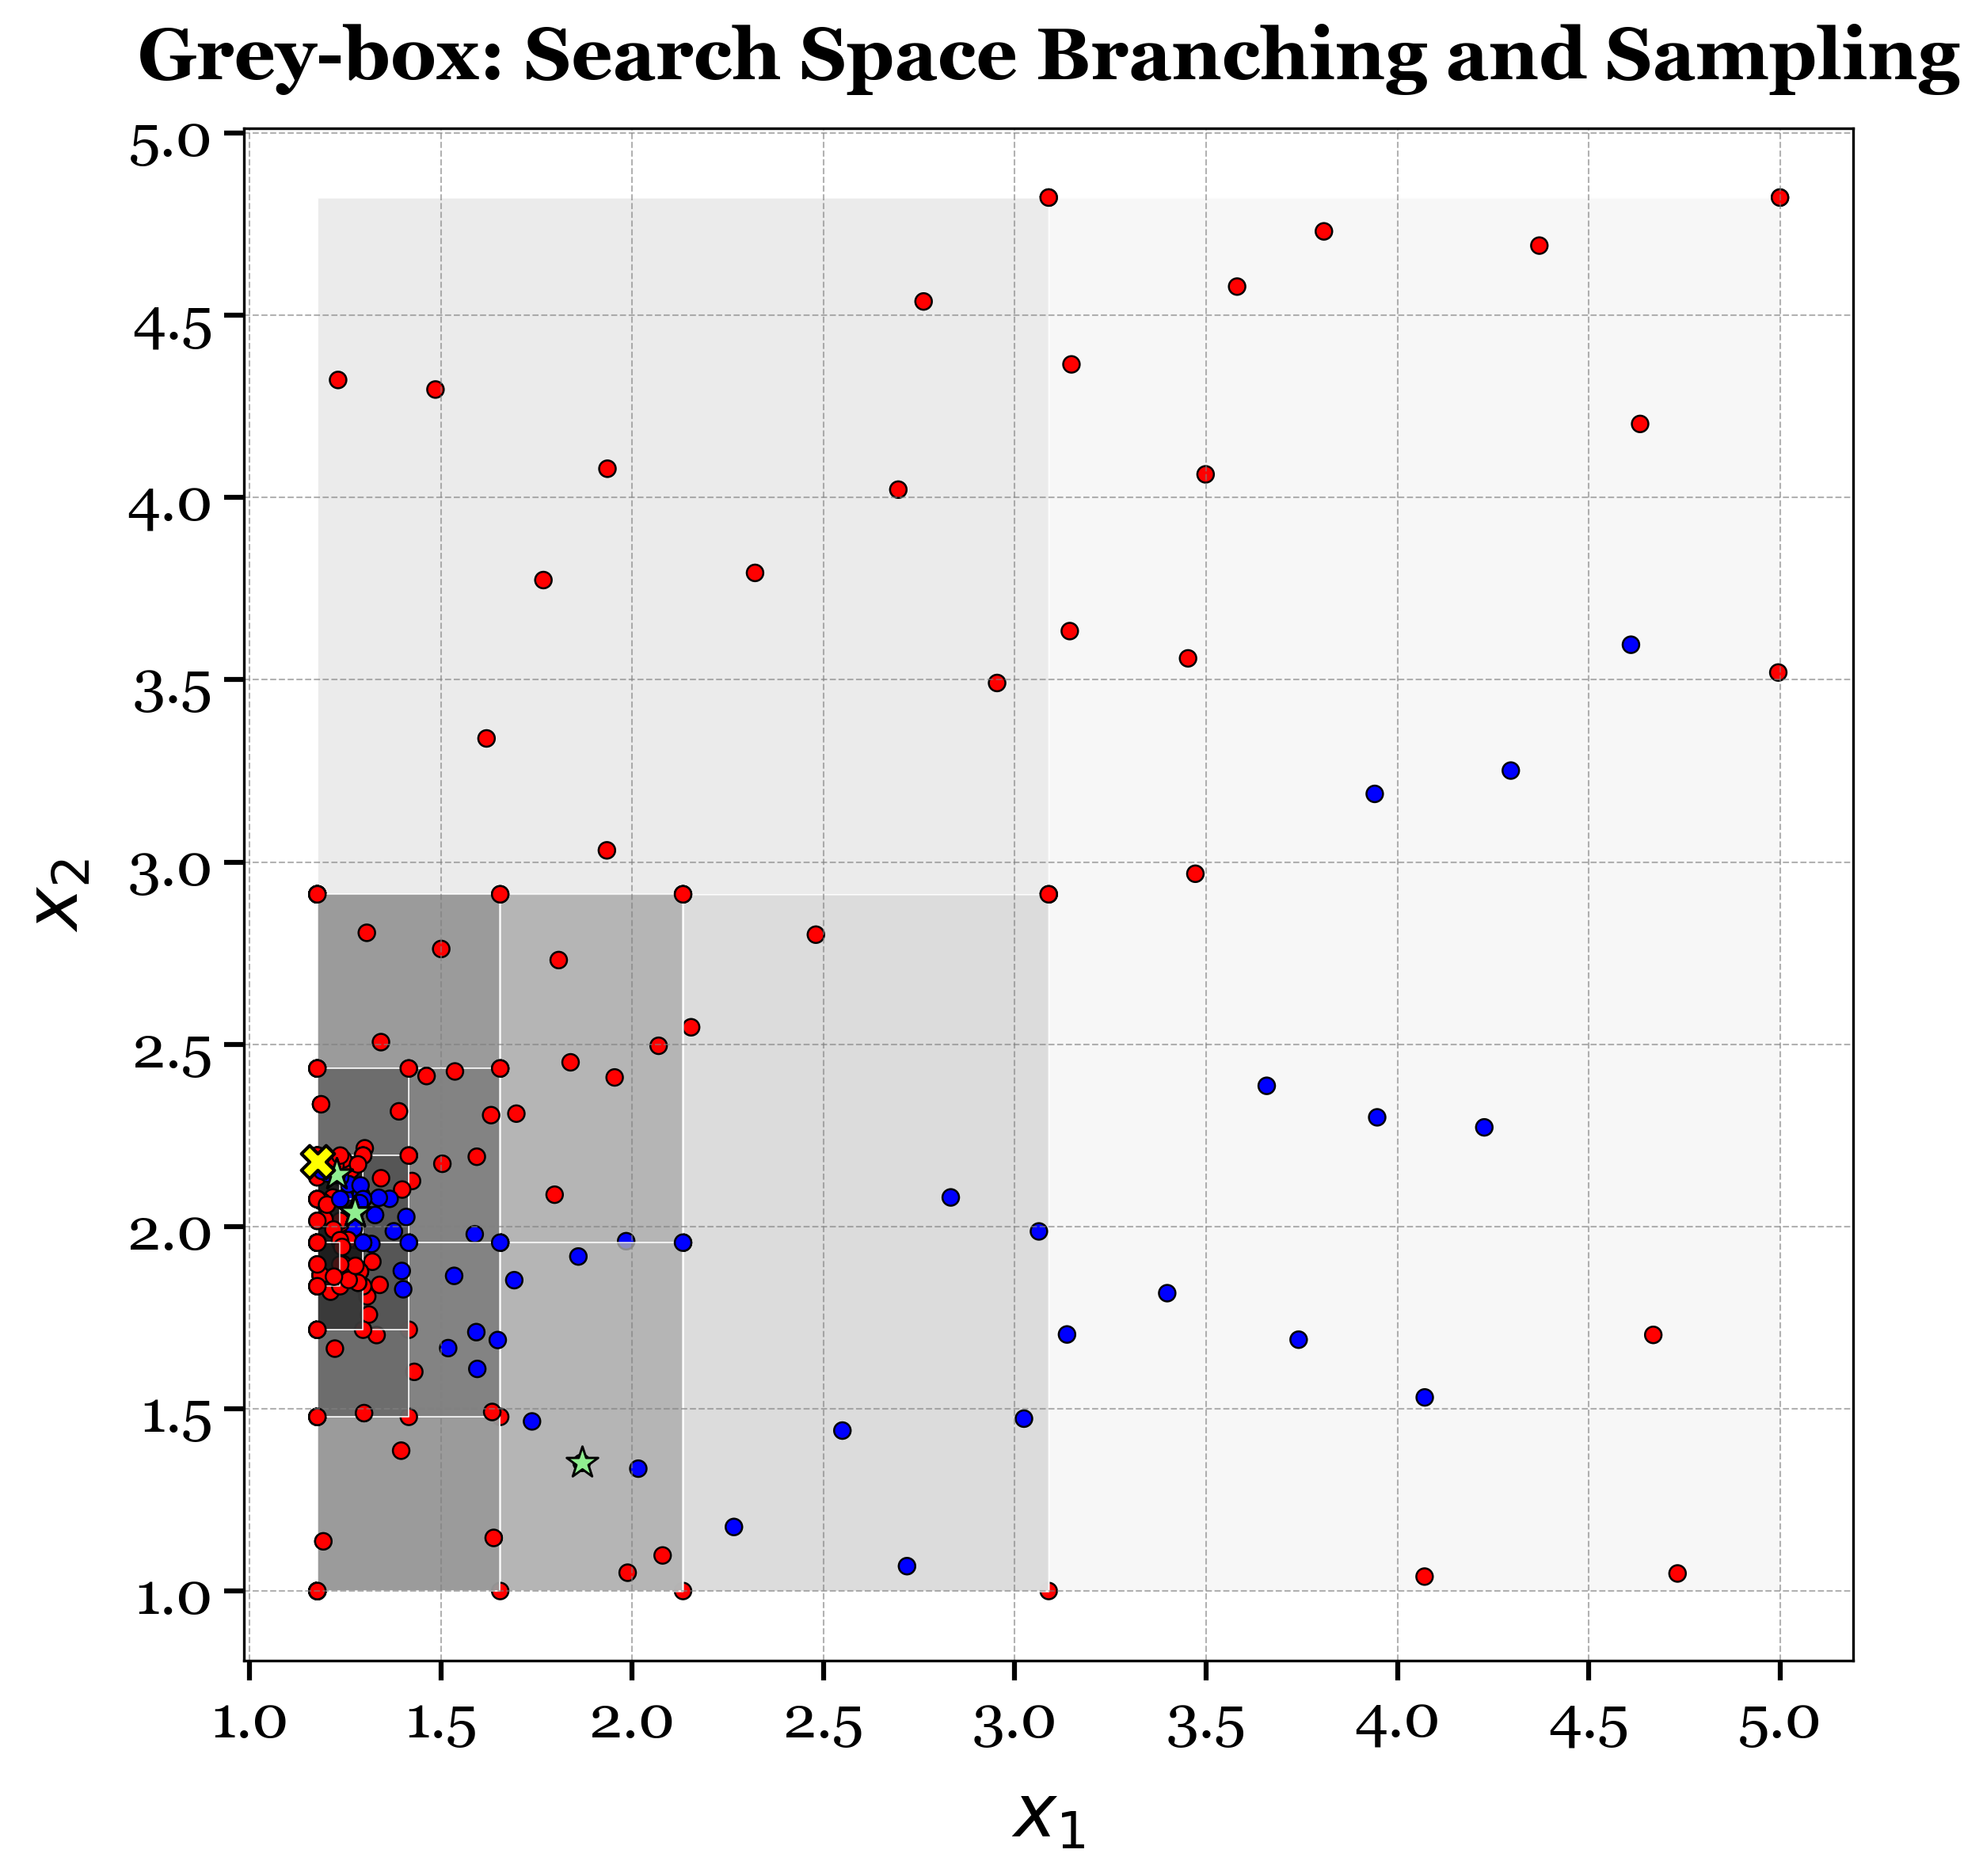

In [26]:
## Grey-box Problem: Search Space Branching and Sampling

fig = plt.figure(figsize=(8, 8), dpi=300)
ax3 = fig.add_subplot(1, 1, 1)

for level in gr_solver.Tree.keys():
    for node in gr_solver.Tree[level].values():
        shade1 = np.arange(node.bounds[0, 0], node.bounds[1, 0], 0.001)
        ax3.fill_between(
            shade1,
            node.bounds[1, 1],
            node.bounds[0, 1],
            facecolor=plt.cm.Greys(level / len(gr_solver.Tree.keys())),
            edgecolor='white',
            linewidth=0.4,
            alpha=0.8
        )

        color = ['red' if lbl == 0 else 'blue' for lbl in node.label]
        ax3.scatter(
            node.x[:, 0],
            node.x[:, 1],
            c=color,
            s=100,
            marker='.',
            edgecolors='black',
            linewidths=0.6
        )

# Plot optimizer history
for xopt in gr_solver._xopt_hist:
    try:
        ax3.scatter(xopt[0], xopt[1], s=100, c='lightgreen', marker='*', edgecolors='black', linewidths=0.7)
    except:
        ax3.scatter(xopt[0, 0], xopt[0, 1], s=100, c='lightgreen', marker='*', edgecolors='black', linewidths=0.7)

# Global optimum
ax3.scatter(1.1771, 2.1771, s=100, c='yellow', marker='X', edgecolors='black', linewidths=1)

ax3.set_xlabel('$x_1$', fontsize=22, fontweight='bold', labelpad=10)
ax3.set_ylabel('$x_2$', fontsize=22, fontweight='bold', labelpad=10)
ax3.tick_params(axis='both', labelsize=18, width=1.5, length=6)
ax3.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
ax3.set_title('Grey-box: Search Space Branching and Sampling', fontsize=22, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()
